# Анализ оттока клиентов в банке «Метанпром»

<a href="https://disk.yandex.ru/i/-1PJSYuDWVSHsw">Презентация</a>

<a href="https://public.tableau.com/app/profile/vladimir5162/viz/metabank/sheet2?publish=yes">Дашборд</a>

## Описание и задачи исследования <a id="#description"></a>

# Цель исследования <a id="#goal_of_research"></a>

Провести анализ оттока клиентов и сегментирование пользователей банка. Выбрать сегменты, соотвествующие критериям и дать по ним рекомендации.

# Источник данных

Датасет содержит данные о клиентах банка «Метанпром». Банк располагается в
Ярославле и областных городах: Ростов Великий и Рыбинск.

# Описание данных

Файл `bank_scrooge.csv`:

Колонки:

* `USERID` — идентификатор пользователя;
* `score` — баллы кредитного скоринга;
* `city` — город;
* `gender` — пол;
* `age` — возраст;
* `equity` — количество баллов собственности;
* `balance` — баланс на счёте;
* `products` — количество продуктов, которыми пользуется клиент;
* `credit_card` — есть ли кредитная карта;
* `last_activity` — был ли клиент активен последнее время;
* `EST_SALARY` — оценочный доход клиента;
* `сhurn` — признак оттока.

# Задачи исследования

* Провести исследовательский анализ данных, определить все значимые
признаки отточности (интервалы значений характеристик, которые связаны с
повышенным оттоком, сравните портреты типичных клиентов, которые
склонны и не склонны уходить из банка и т.д)


* Проверить статистические гипотезы:

    Различие дохода между теми клиентами, которые ушли и теми, которые остались.

    Различие баланса на счете между теми клиентами, которые ушли и теми, которые остались.


* Объединяя признаки отточности, сформировать сегменты, отобрать из них
лучшие и дать по ним рекомендации.

# Открытие данных <a id="#start"></a>

Импортируем все необходимые нам библиотеки и настройки `Pandas` для отображения данных при выводе:

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal
import scipy.stats as stats
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
#import dexplot as dxp
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go

pd.pandas.set_option('display.max_columns', None) #отобразим все колонки таблицы
#округлим числовые значения до сотых, дабы избержать экспоненциального формата данных
pd.options.display.float_format = '{:,.2f}'.format
plt.rcParams["figure.figsize"] = (18, 10)

Прочитаем файлы из папки `/datasets`.

In [2]:
path = '/datasets/'
web_path = 'https://code.s3.yandex.net/datasets/'
data = 'bank_scrooge.csv'

try:
    raw_df = pd.read_csv(path + data)
except:
    raw_df = pd.read_csv(web_path + data)

In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


Выведем на экран 5 случайных строк каждой из таблиц:

In [4]:
raw_df.sample(10)

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
7974,227856,823.00,Ярославль,М,33.00,2,"109,074.72",2,0,0,"142,068.97",0
1586,147973,869.00,Ярославль,М,43.00,4,"1,559,387.93",4,0,0,"168,372.59",1
6885,99999,879.00,Ярославль,М,52.00,4,"1,320,466.73",2,0,0,"140,326.48",1
4768,186742,915.00,Ростов,М,43.00,5,"764,355.98",4,0,0,"157,532.57",0
4511,181880,830.00,Рыбинск,Ж,39.00,4,"455,075.94",2,1,1,"145,942.01",0
5167,116534,885.00,Ярославль,Ж,34.00,4,"2,302,962.61",2,0,1,"203,104.19",1
2621,152465,929.00,Ярославль,Ж,47.00,0,NaN,1,1,0,"163,608.90",0
3356,195785,908.00,Рыбинск,М,24.00,4,"1,450,392.90",2,1,1,"105,294.37",0
7607,179628,717.00,Ярославль,М,26.00,0,NaN,1,1,1,"288,858.69",0
2733,207760,807.00,Ярославль,Ж,41.00,3,"1,207,577.01",2,0,0,"242,034.82",0


Предварительно можно сказать, что в данных имеются пропуски и нулевые значения, но для некоторых столбцов это нормально, с которыми следует разобраться, помимо этого, названия столбцов следуеет привести к «змеиному регистру», а к `gender`стоит применить бинарную классификацию.

## Предобработка данных <a id="#preprocessing"></a>

In [5]:
df = raw_df.copy()

Проведем стандартную предобработку, включающаю проверку явных дубликатов, нулевых и пропущенных значений, а также изменим тип данных и преобразуем категориальные переменные.

Проверим данные на наличие аномалий.

Приведу причины/догадки и аргументы касательно заполнения или удаления значений.

### Преобразование названий столбцов <a id="#names"></a>

Приведем все названия колонок к «змеиному регистру».

In [6]:
df.columns = df.columns.str.replace(" ", "_").str.lower()
df.rename(columns = {'userid' : 'user_id'}, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


### Обработка дубликатов <a id="#description"></a>

In [7]:
print(f"Количество явных дубликатов: {df.duplicated().sum()}. \
Доля: {df.duplicated().sum()/df.shape[0]:.3%}.")

Количество явных дубликатов: 0. Доля: 0.000%.


Теперь проверим данные на неявные дубликаты. В данном датасете только один столбец может иметь уникальные значения — `user_id`, то проверим мы только его, т.к. остальные столбцы имееют непрерывные значения, либо категориальные или булевые переменные.

In [8]:
print(f"Количество неявных дубликатов: {df['user_id'].duplicated().sum()}. \
Доля: {df['user_id'].duplicated().sum()/df.shape[0]:.3%}.")

Количество неявных дубликатов: 73. Доля: 0.730%.


Может показаться, что 73 дубликата — это не так много, но это лишь на первый взгляд, на самом деле это много, потому что баланс этих клиентов может быть довольно весомым, а при учете бюджета фиктивные суммы могут сказаться на его формировании.

Посмотрим на дубликаты более детально, чтобы определить их возможные причины.

In [9]:
id_duplicates = df[df['user_id'].duplicated(keep=False)]
id_duplicates = id_duplicates.iloc[np.lexsort((id_duplicates.index, id_duplicates.user_id.values))]
id_duplicates.head(20)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1893,116540,883.00,Рыбинск,Ж,55.00,1,"362,756.49",3,0,1,"175,920.48",1
7694,116540,887.00,Ярославль,Ж,38.00,0,NaN,1,0,1,"119,247.61",0
4866,117943,855.00,Рыбинск,Ж,32.00,6,"1,036,832.93",4,1,1,"107,792.71",1
7542,117943,880.00,Ярославль,Ж,40.00,0,NaN,1,1,0,"137,718.93",0
5863,120258,908.00,Рыбинск,Ж,38.00,4,"2,213,581.63",2,0,1,"160,327.77",1
5896,120258,905.00,Ярославль,М,30.00,0,NaN,1,1,1,"146,427.96",0
1411,123461,829.00,Ярославль,Ж,59.00,0,"96,222.44",2,0,1,"102,771.55",1
8638,123461,934.00,Рыбинск,М,34.00,0,NaN,2,1,0,"291,619.27",0
8164,124450,859.00,Ярославль,Ж,38.00,6,"516,811.20",1,1,1,"95,144.63",1
9775,124450,758.00,Рыбинск,Ж,36.00,0,"73,574.07",2,0,1,"79,963.59",0


**Попробуем выдвинуть предполагаемые причины:**

1. Новым клиентам присваивают старые идентификаторы, т.к. их прежние владельцы скорее всего закрыли счет, о чем свидетельствуют значения `NaN` в столбце с балансом на счете `balance`, и разный возраст или пол.

2. Клиенты меняют место проживания, из-за чего появляется `user_id` с таким же номером, и с точно таким же возрастом и полом, меняется лишь город. Это говорит о том, что в банке не общая база данных клиентов (например, по региону или в принципе по РФ).

Изучим соотношение неявных дубликатов `user_id` по признаку оттока `churn`:

In [10]:
left_duplicates = id_duplicates.query('churn == 1')
print(f"Количество отточных клиентов в неявных дубликатах: {left_duplicates.shape[0]}. \
Доля: {left_duplicates.shape[0]/df.shape[0]:.3%}.")

Количество отточных клиентов в неявных дубликатах: 50. Доля: 0.500%.


In [11]:
stayed_duplicates = id_duplicates.query('churn == 0')
print(f"Количество действущих клиентов в неявных дубликах: {stayed_duplicates.shape[0]}. \
Доля: {stayed_duplicates.shape[0]/df.shape[0]:.3%}.")

Количество действущих клиентов в неявных дубликах: 96. Доля: 0.960%.


Дубликаты среди действующих клиентов преобладают. Но что если проверить данные группы дубликатов на наличие дубликатов внутри их самих?

In [12]:
print(f"Количество неявных дубликатов среди отточных клиентов: {left_duplicates['user_id'].duplicated().sum()}. \
Доля: {left_duplicates['user_id'].duplicated().sum()/df.shape[0]:.3%}.")

Количество неявных дубликатов среди отточных клиентов: 0. Доля: 0.000%.


In [13]:
print(f"Количество неявных дубликатов среди действующих клиентов: {stayed_duplicates['user_id'].duplicated().sum()}. \
Доля: {stayed_duplicates['user_id'].duplicated().sum()/df.shape[0]:.3%}.")

Количество неявных дубликатов среди действующих клиентов: 23. Доля: 0.230%.


**Исходя из логики можно понять:** 23 действующих клиента имеют дубликаты, а 50 клиентов из оттока перешли в действующих.

In [14]:
left_dup_ids = left_duplicates['user_id'].tolist()
temp = id_duplicates.query('user_id in @left_dup_ids')
temp.iloc[np.lexsort((temp.index, temp.user_id.values))].tail(20)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
869,210662,962.00,Ярославль,Ж,54.00,5,"5,069,231.39",1,1,1,"955,144.85",1
1837,210662,896.00,Рыбинск,Ж,37.00,0,NaN,2,0,0,"90,916.04",0
4986,210792,884.00,Рыбинск,М,48.00,4,"2,228,037.20",2,0,1,"207,978.09",1
7814,210792,839.00,Ярославль,М,42.00,2,"662,646.97",1,1,0,"138,403.60",0
1359,211130,833.00,Ярославль,М,55.00,3,"1,231,184.90",4,0,1,"187,758.38",1
3817,211130,918.00,Рыбинск,Ж,55.00,0,NaN,2,1,1,"244,202.04",0
7055,217412,879.00,Рыбинск,М,42.00,5,"568,140.15",3,0,0,"231,658.67",1
9880,217412,886.00,Ярославль,Ж,35.00,3,"1,026,172.14",2,1,0,"53,099.16",0
4611,217619,903.00,Рыбинск,Ж,59.00,5,"844,055.83",2,0,1,"133,999.76",1
5807,217619,766.00,Ярославль,М,52.00,2,"218,199.47",1,1,0,"120,356.44",0


В рамках закона человек счет может быть переоформлен на другого человека:

1. Когда клиент открывает в банке вклад или счет, он имеет право оставить завещательное распоряжение.

2. Когда клиент желает провести переоформление депозита на другого человека.

Исходя из этой информации о банковских счетах/вкладах можно прийти к логическому объяснению закрытия счета с резкой сменой пола, либо возраста.

К неочевидным причинам также стоит отнести возможность открытия счета в банке спустя годы, либо просто в связи с переездом.

Теперь перейдем к дубликатам среди действующих клиентов.

In [15]:
stayed_duplicates[stayed_duplicates['user_id'].duplicated(keep=False)].head(20)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
4443,127440,846.00,Рыбинск,М,66.00,1,"57,405.67",2,0,1,"17,831.63",0
8785,127440,663.00,Ярославль,М,NaN,0,NaN,1,1,1,"117,197.56",0
4212,140934,919.00,Ярославль,Ж,29.00,4,"603,946.18",3,0,1,"158,438.79",0
9819,140934,832.00,Рыбинск,Ж,NaN,3,"385,763.16",2,0,1,"59,651.35",0
4343,141945,929.00,Рыбинск,М,33.00,0,NaN,1,1,0,"381,868.89",0
9457,141945,929.00,Ярославль,М,NaN,0,NaN,1,1,0,"381,868.89",0
3683,151662,960.00,Ярославль,Ж,37.00,4,"2,527,032.70",4,1,0,"231,648.50",0
5495,151662,884.00,Рыбинск,Ж,NaN,0,NaN,1,1,1,"137,500.77",0
6670,163657,903.00,Рыбинск,М,45.00,4,"1,343,339.70",4,0,1,"83,741.65",0
9667,163657,849.00,Ярославль,М,NaN,4,"1,254,013.85",2,1,1,"119,106.67",0


Какой-то уверенности на их счет нет, но видна зависимость между тем, что город меняется между клиентами в обе стороны — между Ярославлем и Рыбинском, это очень небольшие по населению города, также стоит отметить, что в среди дубликатов действующих клиентов не меняется пол, правда в одном из дубликатов всегда отсутсвует возраст и информация о балансе.

Исходя из этих предположений можно сказать, что вполне при выгрузке и объдинении данных произошла ошибка при индексировании.

Однако, скорее всего проблема связана с частотой обновления информации о клиентах, может быть так, что раньше в каждой локации была своя БД и `user_id` не смогли переприсвоить, либо был какой-то сбой.

Это никак не повляет на анализ данных, т.к. дубликаты составляют лишь 0,73% от всего датасета, поэтому избавлять от дубликатов мы не будем.

### Обработка пропущенных значений <a id="#description"></a>

Создадим таблицы с указанием доли пропусков по каждой колонке, чтобы сэкономить наше время и потом удалить пропуски, или оставить их без изменений, где доля составляет не более 1%.

In [16]:
pd.concat([df.isna().sum(), df.isna().mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
user_id,0,0.00%
score,0,0.00%
city,0,0.00%
gender,0,0.00%
age,26,0.26%
equity,0,0.00%
balance,2295,22.95%
products,0,0.00%
credit_card,0,0.00%
last_activity,0,0.00%


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>

Прошу прощения за вопрос, но бывает так (как сейчас), что формат f-string конфликтует в некоторых датасетах с isna() в связке с mean(): сначала происходит округление (например, 0.2295 окргуляется до 0 и получается 0%), а потом вычисление %, основном с типом данных float64. В чем может быть проблема или это проблема ЮпитерХаба?  
На всякий случай прикрепил скришоты, а то может это у меня проблемы с Юпитером, но вряд ли тогда бы это повторилось.
</div>

Пропуски есть лишь в двух колонках, рассмотрим каждую и постараемся выявить их причины.

In [17]:
df.query('age.isnull()')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
1247,228075,932.00,Ярославль,М,NaN,5,"7,601,719.20",2,1,1,"408,121.16",0
2165,187635,692.00,Рыбинск,Ж,NaN,0,NaN,1,1,1,"160,368.82",0
2444,221156,913.00,Ярославль,М,NaN,0,NaN,1,1,1,"135,693.24",0
3091,138660,836.00,Ростов,Ж,NaN,5,"294,315.53",2,0,1,"63,310.22",1
4912,210674,834.00,Рыбинск,М,NaN,1,"238,330.52",2,0,1,"93,775.06",0
5470,218868,827.00,Рыбинск,Ж,NaN,4,"448,959.07",2,1,1,"67,835.95",0
5495,151662,884.00,Рыбинск,Ж,NaN,0,NaN,1,1,1,"137,500.77",0
7236,210135,908.00,Рыбинск,Ж,NaN,4,"1,120,340.31",3,1,1,"85,002.15",0
7248,219343,920.00,Рыбинск,Ж,NaN,0,NaN,1,1,0,"159,248.67",0
7345,184913,829.00,Ярославль,Ж,NaN,3,"188,648.77",2,0,1,"75,206.90",0


В `age` лишь 26 (0,26%) пропусков. Видно, что в основном возраст неизвестен у клиентов с пропусками в `balance`, где единственным продуктом является кредитная карта, а рейтинг собственности равен 0. Это говорит о том, что скорее всего возраст этих клиентов неизвестен, т.к. они могли лишь оформить заявку на кредитную карту, но еще ее не получили, поэтому данной информации нет в клиентской базе.

In [18]:
df['age'].min()

18.0

Для пропущенных значений в `age` в качестве заглушки будет `-18`, т.к. минимальный возраст клиента составляет 18 лет. Заменить на заглушки их пришлось, т.к. метод `astype` не работает со значениями `NaN` при преобразовании в некоторые типы данных.

In [19]:
df['age'].fillna(-18, inplace=True)

Теперь разрберемся с пропущенными значениями в `balance`.

In [20]:
nbl = df.query('balance.isnull() and churn == 1')
print(f"Количество отточных клиентов c пропусками в балансе: {nbl.shape[0]}. \
Доля: {nbl.shape[0]/df.shape[0]:.3%}.")

Количество отточных клиентов c пропусками в балансе: 13. Доля: 0.130%.


In [21]:
nbnc = df.query('balance.isnull() and credit_card == 0')
print(f"Количество клиентов не имеющих кредитную карту c пропусками в балансе: {nbnc.shape[0]}. \
Доля: {nbnc.shape[0]/df.shape[0]:.3%}.")

Количество клиентов не имеющих кредитную карту c пропусками в балансе: 423. Доля: 4.230%.


In [22]:
nbc = df.query('balance.isnull() and credit_card == 1')
print(f"Количество клиентов имеющих кредитную карту c пропусками в балансе: {nbc.shape[0]}. \
Доля: {nbc.shape[0]/df.shape[0]:.3%}.")

Количество клиентов имеющих кредитную карту c пропусками в балансе: 1872. Доля: 18.720%.


In [23]:
nbcp_2 = df.query('balance.isnull() and credit_card == 1 and products == 1')
print(f"Количество клиентов имеющих только кредитную карту c пропусками в балансе: {nbcp_2.shape[0]}. \
Доля: {nbcp_2.shape[0]/df.shape[0]:.3%}.")

Количество клиентов имеющих только кредитную карту c пропусками в балансе: 1599. Доля: 15.990%.


In [24]:
nb = df.query('balance == 0')
print(f"Количество клиентов имеющих нулевой баланс баланс: {nb.shape[0]}. \
Доля: {nb.shape[0]/df.shape[0]:.3%}.")

Количество клиентов имеющих нулевой баланс баланс: 2. Доля: 0.020%.


Нулевые значения практически отсутсвуют — их всего 2 и потому что у большинства этих клиентов единственным продуктом является кредитная, а у других по разным причинам просто может быть 0 или они просто пользуются другими банковскими продуктами.

In [25]:
df.query('balance >= 0').describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,"7,705.00","171,738.84","33,819.78","94,561.00","142,639.00","172,740.00","201,168.00","229,136.00"
score,"7,705.00",843.74,55.33,689.00,801.00,840.00,882.00,"1,000.00"
age,"7,705.00",42.85,12.43,-18.00,33.00,40.00,52.00,86.00
equity,"7,705.00",3.40,1.58,0.00,2.00,4.00,5.00,9.00
balance,"7,705.00","827,794.31","1,980,614.15",0.00,"295,554.16","524,272.20","980,705.85","119,113,552.01"
products,"7,705.00",2.08,0.76,1.00,2.00,2.00,2.00,5.00
credit_card,"7,705.00",0.64,0.48,0.00,0.00,1.00,1.00,1.00
last_activity,"7,705.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
est_salary,"7,705.00","124,501.87","104,663.54","2,546.30","67,551.81","106,222.20","155,045.67","1,395,064.45"
churn,"7,705.00",0.23,0.42,0.00,0.00,0.00,0.00,1.00


In [26]:
df.query('balance.isna()').describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,"2,295.00","172,069.45","33,337.08","114,182.00","143,095.50","172,659.00","201,551.00","229,145.00"
score,"2,295.00",865.35,89.60,642.00,871.00,903.00,922.00,990.00
age,"2,295.00",41.67,12.91,-18.00,33.00,40.00,49.00,86.00
equity,"2,295.00",0.05,0.23,0.00,0.00,0.00,0.00,3.00
balance,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
products,"2,295.00",1.16,0.40,0.00,1.00,1.00,1.00,3.00
credit_card,"2,295.00",0.82,0.39,0.00,1.00,1.00,1.00,1.00
last_activity,"2,295.00",0.55,0.50,0.00,0.00,1.00,1.00,1.00
est_salary,"2,295.00","226,310.21","199,771.79","20,274.03","120,347.70","174,160.68","240,014.99","1,333,687.36"
churn,"2,295.00",0.01,0.08,0.00,0.00,0.00,0.00,1.00


Из описанных срезов методом `describe()` видно, в основном баланс пропусками у следующих клиентов:
- баллы кредитного скоринга от 865;
- средний возраст: 42 года;
- 1 продукт;
- у 82% есть кредитная карта;
- 55% были активны последнее время;
- отток составляет 1%.

In [27]:
df.loc[df['balance'].isna()].groupby('products').agg({'user_id':'count'})

,user_id
products,
0,1
1,1950
2,315
3,29


Скорее всего пропуски вызваны какой-то системной ошибкой при сборе данных, проблемными являются действующие клиенты, в основном у которых единственным банковским продуктов является кредитная карта. Единственной разницей между нормальными данными является доход, который в 2 раза выше среднего, либо на 50% выше медианного значения в датасете с нормальными данными.

Заполнять нулями данные строки мы не будем, чтобы не искажать дальнейший исследовательский анализ.

### Обработка нулевых значений <a id="#description"></a>

Создадим таблицы с указанием доли нулевых значений по каждой колонке.

In [28]:
pd.concat([df.eq(0).sum(), df.eq(0).mean()],
          axis=1, keys=['sum', 'conversation']).style.format({'conversation': '{:.2%}'}).background_gradient('coolwarm')

,sum,conversation
user_id,0,0.00%
score,0,0.00%
city,0,0.00%
gender,0,0.00%
age,0,0.00%
equity,2592,25.92%
balance,2,0.02%
products,1,0.01%
credit_card,3196,31.96%
last_activity,4765,47.65%


In [29]:
df.query('balance == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
3900,179831,730.00,Ярославль,М,18.00,0,0.00,2,1,1,"64,548.33",0
6757,148456,813.00,Ярославль,М,20.00,2,0.00,2,1,0,"23,876.51",0


Клиенты являются действующими, просто пользуются другими банковскими продуктами, предположительно сегментом кредитования и кредитной картой.

In [30]:
df.query('products == 0')

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8957,147837,962.00,Рыбинск,Ж,79.00,3,NaN,0,0,0,"25,063.96",1


Лишь один клиент имеет 0 продуктов, это говорит о том, что он не думает уйти, а уже ушел в отток — закрыл все счет и перестал быть действующим клиентом нашего банка.

Удалим его, т.к. он полностью перестал быть действующим.

In [31]:
df.drop(index=df.index[8957], axis=0, inplace=True)

Данные имеют немало нулевых значений, но для данного сегмента бизнеса такие цифры нормальны, также не стоит забывать, что многие из колонок имеют значения, к которым была применена бинарная классификация.

**Применена бинарная классифкация для:**
- `credit_card` — есть ли кредитная карта;
- `last_activity` — был ли клиент активен последнее время;
- `churn` — признак оттока.

**Свойственны для:**
- `equity` — количество баллов собственности может быть нулевым, если у клиента нет недвижимости или иной собственности;
- `balance` — баланс на счёте также может быть равен нулю, если у клиента счет открыт недавно, он снял все средства, либо единственным банковским продуктом является кредитная карта;
- `products` — количество продуктов, которыми пользуется клиент может быть нулевым, когда он задолго перестает пользоваться банковскими продуктами и в последствии переходит в отток.

### Преобразование типов данных <a id="#description"></a>

In [32]:
df['score'].unique()

array([ 850.,  861.,  892.,  866.,  730.,  856.,  807.,  825.,  923.,
        906.,  927.,  921.,  845.,  837.,  815.,  731.,  829.,  793.,
        876.,  922.,  772.,  896.,  871.,  732.,  898.,  806.,  766.,
        776.,  868.,  946.,  828.,  786.,  944.,  863.,  822.,  794.,
        924.,  811.,  814.,  956.,  935.,  826.,  849.,  901.,  893.,
        792.,  888.,  831.,  748.,  820.,  860.,  914.,  930.,  948.,
        789.,  737.,  812.,  933.,  809.,  749.,  873.,  859.,  950.,
        937.,  835.,  768.,  767.,  785.,  846.,  750.,  816.,  894.,
        891.,  788.,  758.,  787.,  821.,  855.,  779.,  791.,  838.,
        971.,  797.,  841.,  915.,  985.,  870.,  897.,  763.,  774.,
        686., 1000.,  875.,  819.,  869.,  854.,  810.,  761.,  802.,
        958.,  917.,  745.,  736.,  908.,  928.,  884.,  853.,  780.,
        726.,  881.,  975.,  852.,  965.,  899.,  890.,  836.,  818.,
        880.,  795.,  916.,  775.,  902.,  918.,  842.,  771.,  895.,
        801.,  721.,

In [33]:
df['age'].unique()

array([ 25.,  37.,  30.,  51.,  34.,  56.,  39.,  38.,  54.,  67.,  52.,
        41.,  31.,  28.,  35.,  42.,  45.,  53.,  40.,  43.,  47.,  48.,
        61.,  62.,  36.,  26.,  27.,  60.,  72.,  50.,  46.,  55.,  58.,
        71.,  44.,  49.,  33.,  32.,  66.,  29.,  68.,  73.,  69.,  59.,
        21.,  65.,  57.,  63.,  80.,  24.,  70.,  77.,  64.,  23.,  20.,
        18.,  19.,  78.,  74.,  76.,  22.,  75., -18.,  83.,  82.,  81.,
        84.,  79.,  86.])

Заменим с помощью метода `astype()`:

* вещественный тип данных в столбце `score` баллы кредитного скоринга (максимум 1000) на целочисленный `int`;
* вещественный тип данных в столбце `age` возраст на целочисленный `int`.

In [34]:
df = df.astype({'score':'int','age':'int'})
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        9999 non-null   int64  
 1   score          9999 non-null   int64  
 2   city           9999 non-null   object 
 3   gender         9999 non-null   object 
 4   age            9999 non-null   int64  
 5   equity         9999 non-null   int64  
 6   balance        7705 non-null   float64
 7   products       9999 non-null   int64  
 8   credit_card    9999 non-null   int64  
 9   last_activity  9999 non-null   int64  
 10  est_salary     9999 non-null   float64
 11  churn          9999 non-null   int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 1015.5+ KB


### Добавление новых столбцов <a id="#description"></a>

Для того, чтобы применять среднее и смотреть корреляции какого-то числового показателя с категориальным неупорядоченным в колонках `city` и `gender`, применим one-hot кодирование при помощи `pandas.get_dummies()`. На всякий случай создадим оригинальный копии этих столбцов, т.к. они могут понадобиться нам в будущем.

In [35]:
temp_df = df
df = pd.get_dummies(df)
df.insert(2, 'city', temp_df['city'])
df.insert(3, 'gender', temp_df['gender'])
df

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,city_Ростов,city_Рыбинск,city_Ярославль,gender_Ж,gender_М
0,183012,850,Рыбинск,Ж,25,1,"59,214.82",2,0,1,"75,719.14",1,False,True,False,True,False
1,146556,861,Рыбинск,Ж,37,5,"850,594.33",3,1,0,"86,621.77",0,False,True,False,True,False
2,120722,892,Рыбинск,Ж,30,0,NaN,1,1,1,"107,683.34",0,False,True,False,True,False
3,225363,866,Ярославль,Ж,51,5,"1,524,746.26",2,0,1,"174,423.53",1,False,False,True,True,False
4,157978,730,Ярославль,М,34,5,174.00,1,1,0,"67,353.16",1,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,120553,814,Рыбинск,М,27,1,"78,144.65",1,0,1,"18,943.64",0,False,True,False,False,True
9996,139170,894,Ярославль,М,46,0,NaN,1,1,0,"196,898.29",0,False,False,True,False,True
9997,115639,903,Ярославль,М,24,0,NaN,2,1,1,"108,905.09",0,False,False,True,False,True
9998,148700,777,Ярославль,Ж,68,3,"865,457.97",3,0,1,"86,874.90",0,False,False,True,True,False


### Анализ данных на наличие аномальных значений <a id="#description"></a>

Исследуем данные, используя функцию `describe`.

In [36]:
df.describe(include=[np.number]).transpose()

,count,mean,std,min,25%,50%,75%,max
user_id,"9,999.00","171,817.11","33,709.07","94,561.00","142,809.50","172,740.00","201,262.50","229,145.00"
score,"9,999.00",848.69,65.44,642.00,802.00,853.00,900.00,"1,000.00"
age,"9,999.00",42.57,12.55,-18.00,33.00,40.00,51.00,86.00
equity,"9,999.00",2.63,1.98,0.00,0.00,3.00,4.00,9.00
balance,"7,705.00","827,794.31","1,980,614.15",0.00,"295,554.16","524,272.20","980,705.85","119,113,552.01"
products,"9,999.00",1.87,0.79,1.00,1.00,2.00,2.00,5.00
credit_card,"9,999.00",0.68,0.47,0.00,0.00,1.00,1.00,1.00
last_activity,"9,999.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
est_salary,"9,999.00","147,879.17","139,390.07","2,546.30","75,252.12","119,661.51","174,501.12","1,395,064.45"
churn,"9,999.00",0.18,0.39,0.00,0.00,0.00,0.00,1.00


Наблюдаются большие максимальные значения в некоторых колонках, но для исследуемого сегмента бизнеса это нормально, поэтому такие значения нельзя назвать аномалиями, а скорее уникальными или нетипичными.

Из таблицы также видно, что:
- средний балл кредитного скоринга составляет **848,7**;
- больше всего клиентов в Ярославле — **59%**;
- средний возраст клиента — **42 года**;
- женщин и мужчин поровну;
- средний баланс на счете — **637 815 руб.**;
- у **68%** клиентов есть кредитная карта;
- **52%** клиентов были активны в последнее время (30 дн.);
- средний оценочный доход клиента — **147 866 руб.**;
- отточными являются лишь **18%** клиентов.

### Вывод <a id="#description"></a>

Как выяснилось, аномалии отсутсвуют.

Также названия столбцов были приведены к «змеиному регистру» и к `score`, `age` были применены соответсвующие типы данных.

Создали дополнительные столбцы для `city` и `gender`, применив one-hot кодирование при помощи `pandas.get_dummies()`.

Были выявлены нулевые значения, но для данного сегмента бизнеса такие цифры нормальны, также не стоит забывать, что многие из колонок имеют значения, к которым была применена бинарная классификация.

У большинства этих клиентов с пропусками в `balance` единственным продуктом является кредитная, а других по разным причинам просто может быть 0 или они просто пользуются другими банковскими продуктами, поэтому мы заполнили эти пропуски нулями.

В данных есть неявные дубликаты в `user_id`.

**Были выявлены слеюущие предполагаемые причины дубликатов в `user_id`:**

1. Клиенты закрывают счет в одном городе, но потом открывают его в другом, либо просто спустя годы возвращаются в наш банк после долгого времени пребывания в оттоке.

2. Счет или депозит были переоформлены или унаследованы другими лицами.

3. При выгрузке и объдинении данных произошла ошибка при индексировании.

4. В каждой локации была своя БД и `user_id` не смогли переприсвоить, либо был какой-то сбой.


**Из описания среза методом `describe()` видно, в основном баланс пропусками у следующих клиентов:**
- баллы кредитного скоринга от 865;
- средний возраст: 42 года;
- 1 продукт;
- у 82% есть кредитная карта;
- 55% были активны последнее время;
- отток составляет 1%.


Однако, скорее всего наблюдается какая-то техническая ошибка в БД в момент открытия счета или при выгрузке данных из БД, т.к. дубликаты есть только в Рыбинске и Ярославле, а пропуски в `balance` преимущественно в Ярославле.

## Портреты клиентов

В данной главе мы детально изучим портреты клиентов на основе их признаков.

* Изучим средние и медианные значения каждого признака клиента;
* Посмотрим на распределения признаков в разрезе оттока;
* Проверим возможные взаимные корреляции.

В результате анализа данной главы сформируем вывод с возможными предпосылками сегментации.

### Непрерывные значения

#### Анализ баллов кредитного скоринга

In [37]:
fig = px.box(df, x="score")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха баллов кредитного скоринга',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_title='Баллы',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.show()

fig = px.box(df, x="score", color="churn")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха баллов кредитного скоринга в разрезе оттока',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_title='Баллы',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.show()

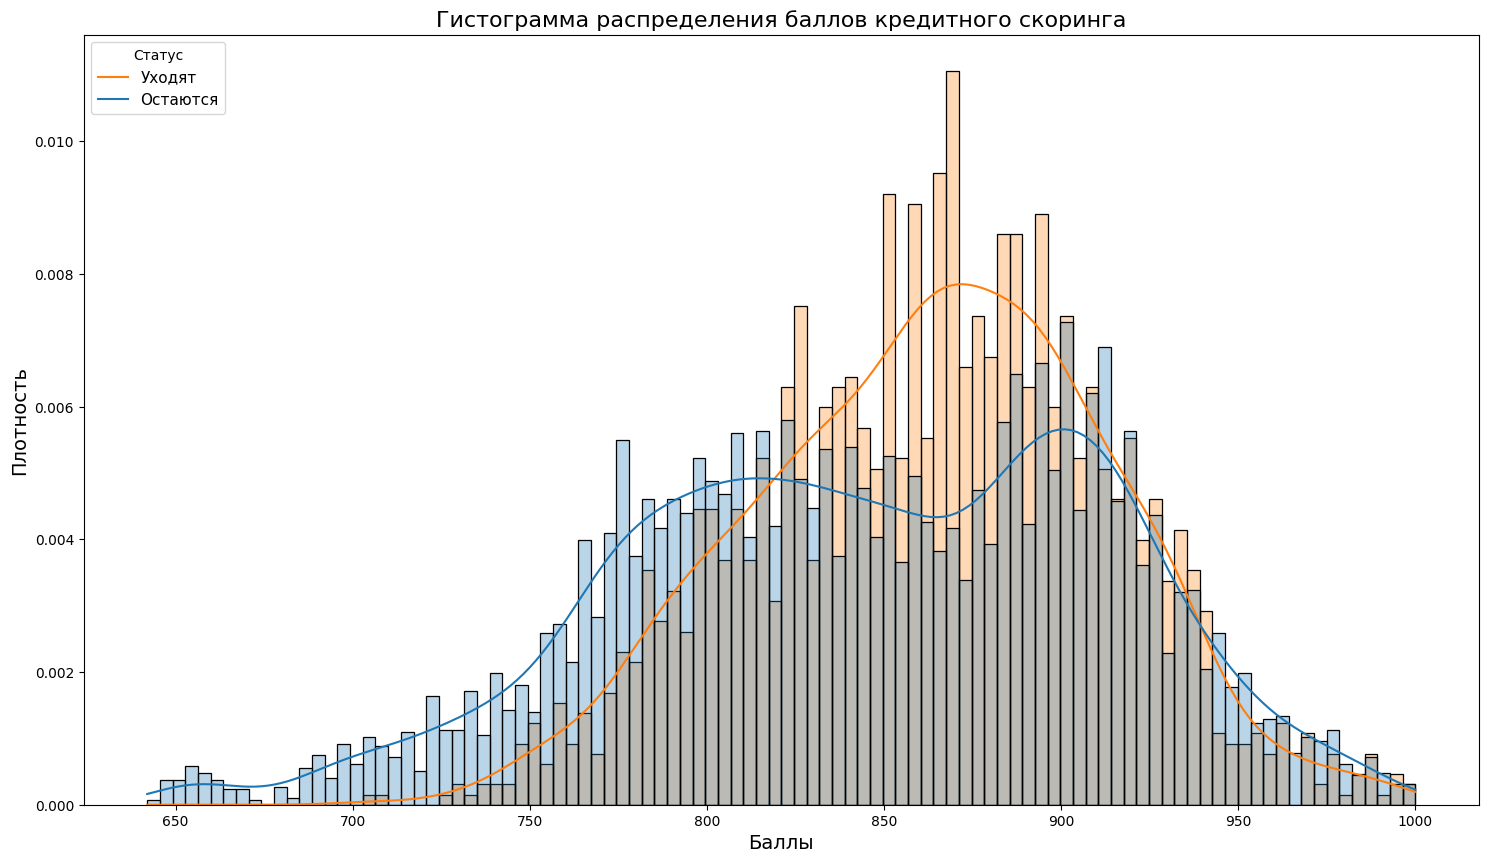

In [38]:
sns.histplot(
    df, x="score", hue="churn", bins=100, alpha=0.3,
    stat="density", common_norm=False, kde=True
)
plt.title('Гистограмма распределения баллов кредитного скоринга', fontsize=16)
plt.xlabel('Баллы', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.legend(title='Статус', loc='upper left', labels=['Уходят', 'Остаются'], fontsize=11)
plt.show()

Среднее значение среди всех клиентов: 848,69;

Среднее значение среди оставшихся клиентов: 845,43;

**Среднее значение среди думающих уйти клиентов:** **863,4**;

Медианное значение среди всех клиентов: 853;

Медианное значение среди оставшихся клиентов: 848;

**Медианное значение среди думающих уйти клиентов:** **866**;

Аномалии: отсутсвуют;

Выбросы: практически отсутсвуют;

Распределение: отток приходится на значения **от 825 до 910 баллов**.

**Вывод:** средние и медианные значения особо не отличаются, баллы среди клиентов думающих уйти незначительно выше. Отток в основном приходится на клиентов, имеют **от 796 до 900 баллов**.

#### Анализ возраста

In [39]:
temp_age = df.query('age > 0')

fig = px.box(temp_age, x='age')
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха возраста клиентов',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_title='Возраст',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.show()

fig = px.box(temp_age, x='age', color="churn")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха возраста клиентов в разрезе оттока',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_title='Возраст',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.show()

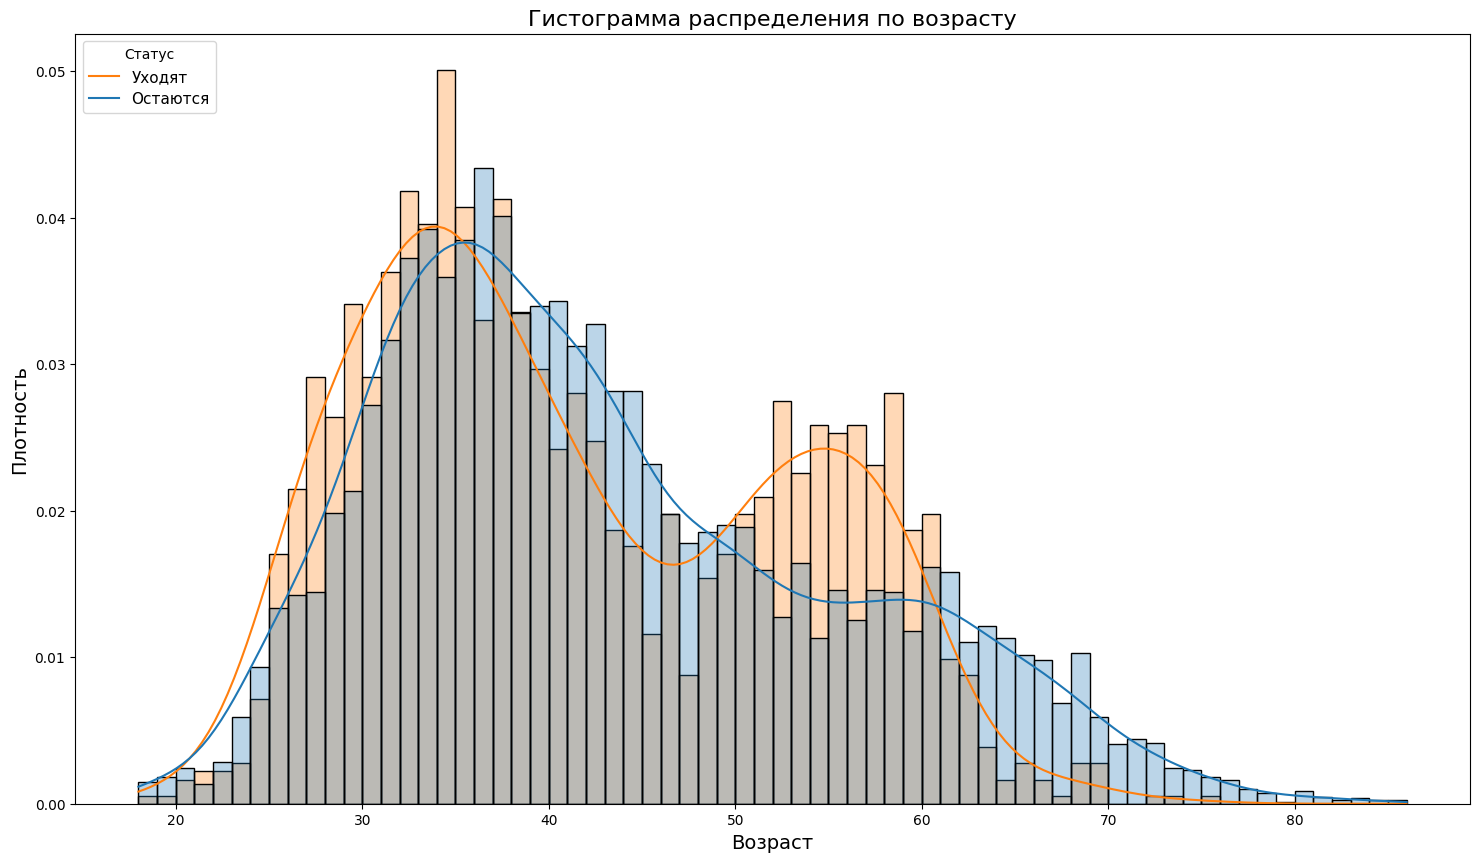

In [40]:
sns.histplot(
    temp_age, x="age", hue="churn", binwidth=1, alpha=0.3,
    stat="density", common_norm=False, kde=True
)
plt.title('Гистограмма распределения по возрасту', fontsize=16)
plt.xlabel('Возраст', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.legend(title='Статус', loc='upper left', labels=['Уходят', 'Остаются'], fontsize=11)
plt.show()

Среднее значение среди всех клиентов: 42;

Среднее значение среди оставшихся клиентов: **43**;

**Среднее значение среди думающих уйти клиентов:** 41;

Медианное значение среди всех клиентов: 40;

Медианное значение среди оставшихся клиентов: 40;

**Медианное значение среди думающих уйти клиентов:** 39;

Аномалии: отсутсвуют;

Выбросы: практически отсутсвуют;

Распределение: отток приходится на 2 возрастные группы: **от 25 до 33 лет** и **от 50 до 60 лет**.

**Вывод:** средние и медианные значения особо не отличаются. Основная доля оттока приходится на клиентов **от 34 до 51 года**

#### Анализ баланса на счете

In [41]:
df['balance'].describe()

count         7,705.00
mean        827,794.31
std       1,980,614.15
min               0.00
25%         295,554.16
50%         524,272.20
75%         980,705.85
max     119,113,552.01
Name: balance, dtype: float64

In [42]:
temp_balance = df.query('0 < balance < 2000000')

fig = px.box(df, x="balance")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха баланса на счете',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_range=[df['balance'].min(), df['balance'].median()*6],
                  xaxis_title='руб.',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.show()

fig = px.box(df, x="balance", color="churn")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха баланса на счете в разрезе оттока',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_range=[-5, df['balance'].median()*6],
                  xaxis_title='руб.',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.show()

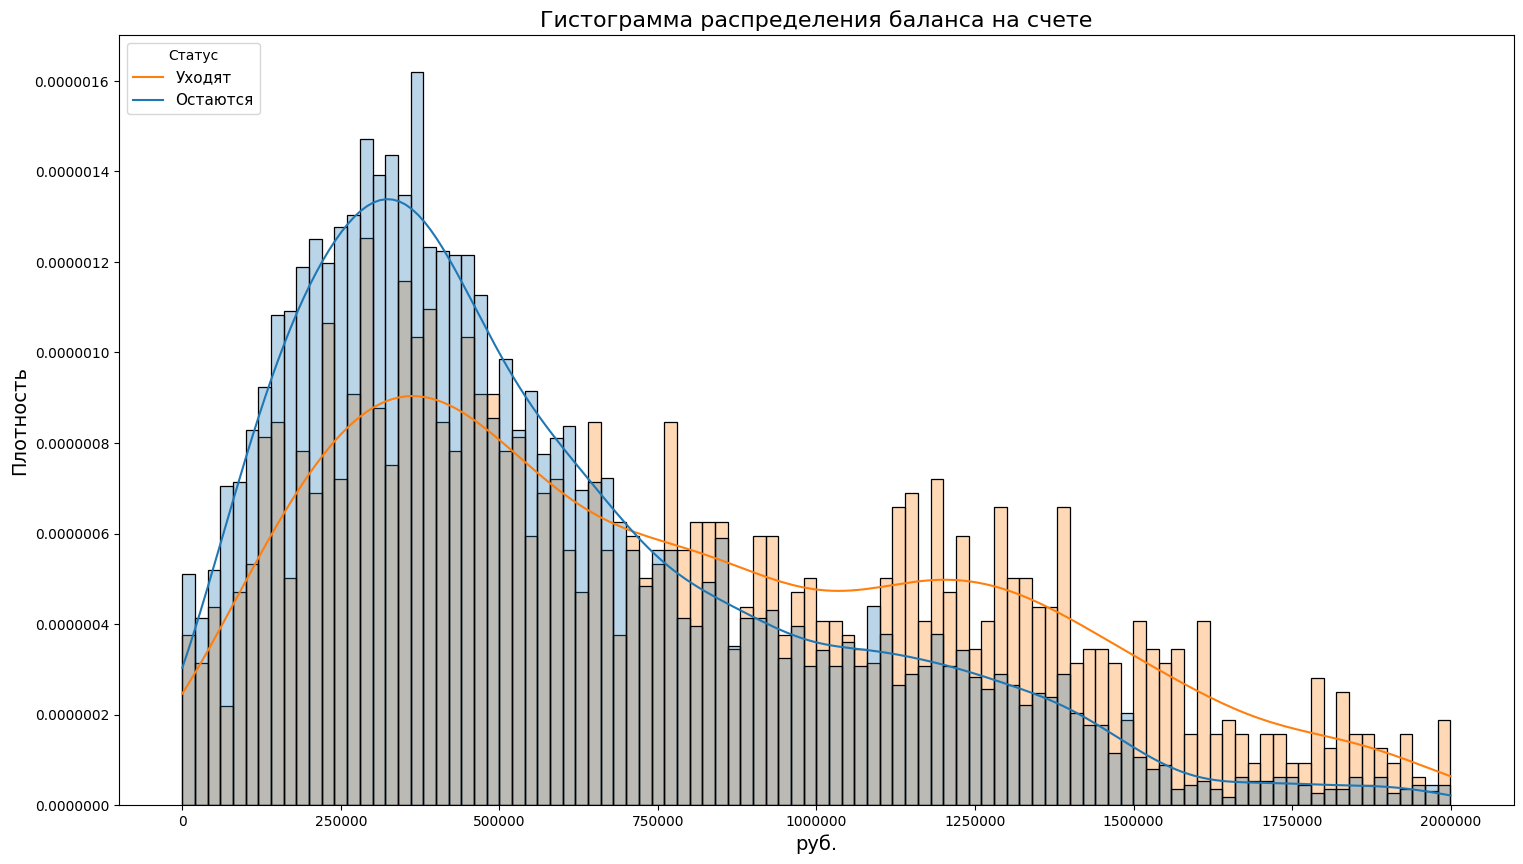

In [43]:
sns.histplot(
    temp_balance, x="balance", hue="churn", bins=100, alpha=0.3,
    stat="density", common_norm=False, kde=True
)
plt.title('Гистограмма распределения баланса на счете', fontsize=16)
plt.xlabel('руб.', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.legend(title='Статус', loc='upper left', labels=['Уходят', 'Остаются'], fontsize=11)
#plt.xlim(0, 2000000)
plt.ticklabel_format(style = 'plain')
plt.show()

<div class="alert alert-info"><b>Комментарий студента:</b>
    
Пришлось отобразить распределение через срез, т.к. лимиты искажают график.
    
</div>

Среднее значение среди всех клиентов: 827,79 тыс.;

Среднее значение среди оставшихся клиентов: 733,89 тыс.;

**Среднее значение среди думающих уйти клиентов:** **1,133 млн.**;

Медианное значение среди всех клиентов: 524,27 тыс.;

Медианное значение среди оставшихся клиентов: 475,38 тыс.;

**Медианное значение среди думающих уйти клиентов:** **775,34 тыс.**;

Аномалии: отсутсвуют;

Выбросы: присутствуют после 1,99 млн. среди всех клиентов;

Распределение: отток приходится на клиентов с балансом на счете **от 750 тыс. рублей и выше**.

**Вывод:** средние и медианные значения отличаются из-за специфики признака, суммы балансов на счете клиентов думающих уйти почти в 2,5 раза выше по медиане.  Отток в основном приходится на клиентов, имеющих **от 381 тыс. до 1,347 млн.**

#### Анализ оценочного дохода

In [44]:
temp_balance = df.query('balance > 0')

fig = px.box(df, x="est_salary")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха оценочного дохода',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_range=[df['balance'].min(), df['balance'].median()*1.2],
                  xaxis_title='руб.',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.show()

fig = px.box(df, x="est_salary", color="churn")
fig.update_layout(legend_title_text=None,
                 title={
                      'text': 'Диаграмма размаха размаха оценочного дохода',
                      'xanchor': 'center',
                      'y':0.95,
                      'x':0.5},
                  xaxis_range=[-5, df['balance'].median()*1.2],
                  xaxis_title='руб.',
                  yaxis_title='')
fig.update_traces(boxmean=True)
fig.show()

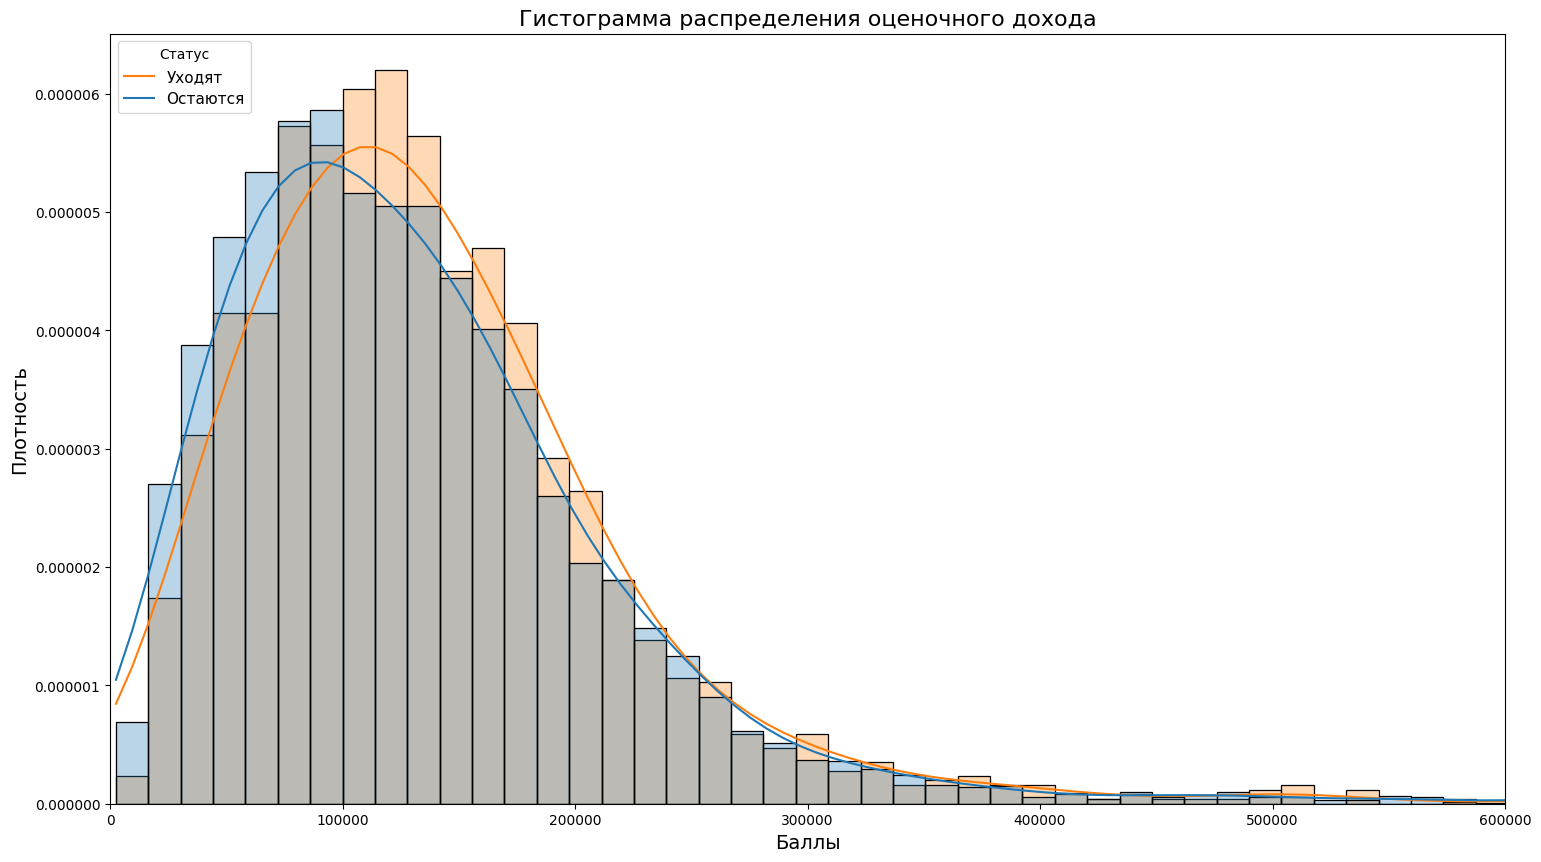

In [45]:
sns.histplot(
    df, x="est_salary", hue="churn", bins=100, alpha=0.3,
    stat="density", common_norm=False, kde=True
)
plt.title(f'Гистограмма распределения оценочного дохода', fontsize=16)
plt.xlabel('Баллы', fontsize=14)
plt.ylabel('Плотность', fontsize=14)
plt.legend(title='Статус', loc='upper left', labels=['Уходят', 'Остаются'], fontsize=11)
plt.xlim(0, 600000)
plt.ticklabel_format(style = 'plain')
plt.show()

Среднее значение среди всех клиентов: 147,86 тыс.;

Среднее значение среди оставшихся клиентов: 147,78 тыс.;

**Среднее значение среди думающих уйти клиентов:** **148,24 тыс.**;

Медианное значение среди всех клиентов: 119,65 тыс.;

Медианное значение среди оставшихся клиентов: 118,25 тыс.;

**Медианное значение среди думающих уйти клиентов:** **125,39 тыс.**;

Аномалии: отсутсвуют;

Выбросы: присутствуют после 323 тыс. среди всех клиентов;

Распределение: нормальное, отток приходится на клиентов с оценочным доходом **от 100 тыс. до 200 тыс. рублей**.

**Вывод:** средние и медианные значения отличаются примерно на 25%, суммы балансов на счете клиентов думающих почти в 2,5 раза выше по медиане.  Отток в основном приходится на клиентов, имеющих оценочный доход **от 83 тыс. до 176 тыс.**

### Дискретные значения

Напишем функцию для дискретных значий, чтобы тратить меньше времени на построение сводных таблиц и графиков.

In [46]:
#на вход функция принимает колонку необходимого параметра
def disc_values(column):
    #строим сводную таблицу
    pivot_column = df.pivot_table(index=column, columns='churn', aggfunc={'user_id':'count'}).reset_index()
    pivot_column.columns = pivot_column.columns.droplevel(1)
    pivot_column.columns = [column, '0', '1']
    pivot_column['churn'] = (pivot_column['1'] / (pivot_column['0'] + pivot_column['1'])*100).round(2)
    display(pivot_column)

    #строим график распределения в разрезе оттока
    plt.figure(figsize=(8, 12))
    bins=df[column].nunique()
    sns.histplot(
        df,
        x=column,
        hue='churn',
        bins=bins,
#        palette=['green','red'],
        multiple="stack"
    ).set_xticks(pivot_column[column].unique())
    plt.title(f'Гистограмма распределения {column}', fontsize=16)
    plt.ylabel('Кол-во клиентов', fontsize=14)
    plt.legend(title='Статус', loc='upper left', labels=['Уходят', 'Остаются'], fontsize=11)
    plt.show()


    plt.subplots(figsize=(8, 8))
    sns.barplot(x=column, y='churn', data=pivot_column)
    plt.title(f'Уровень оттока {column}', fontsize=16)
    plt.ylabel('Отток, %', fontsize=14)
    plt.show()

    print('Средний отток клиентов внутри всей категории по банку:', int(pivot_column['1'].mean()),\
         'Доля, %:', int(pivot_column['churn'].mean()))
    print(len(pivot_column[column]))

Напишем функцию для бинарных дискретных значий

In [47]:
#на вход функция принимает колонку необходимого параметра и бинарные парметры для каждого
def binary_disc_values(column, status_1, status_2):
    #строим сводную таблицу
    pivot_column = df.pivot_table(index=column, columns='churn', aggfunc={'user_id':'count'}).reset_index()
    pivot_column.columns = pivot_column.columns.droplevel(1)
    pivot_column.columns = [column, '0', '1']
    pivot_column['churn'] = (pivot_column['1'] / (pivot_column['0'] + pivot_column['1'])*100).round(2)
    display(pivot_column)

    #строим график распределения в разрезе оттока
    plt.figure(figsize=(8, 10))
    bins=df[column].nunique()
    ax = sns.histplot(
        df,
        x=column,
        hue='churn',
        bins=bins,
        multiple="stack",
        discrete=True
    )
    plt.title(f'Гистограмма распределения {column}', fontsize=16)
    plt.ylabel('Кол-во клиентов', fontsize=14)
    plt.legend(title='Статус', loc='upper left', labels=['Уходят', 'Остаются'], fontsize=11)
    ax.set_xticks(pivot_column[column].unique())
    #    ax.set_xticks([0, 1])
    ax.set_xticklabels([status_1, status_2])
    plt.show()

    plt.subplots(figsize=(8, 8))
    sns.barplot(x=column, y='churn', data=pivot_column)
    plt.title(f'Уровень оттока {column}', fontsize=16)
    plt.ylabel('Отток, %', fontsize=14)
    plt.show()

    print('Средний отток клиентов внутри всей категории по банку:', int(pivot_column['1'].mean()),\
         'Доля, %:', int(pivot_column['churn'].mean()))


Внутри каждой колонки (категории) будет своя средняя доля оттока, чтобы определить саммые отточные параметры в целом. Однако, в качестве среднего итогового ориентира при анализе разбивки категорий на подгруппы будет **средняя доля оттока по всему датасету**, которая составляет **18%**.

#### Анализ клиентов по городам

,city,0,1,churn
0,Ростов,1151,266,18.77
1,Рыбинск,2258,436,16.18
2,Ярославль,4771,1117,18.97


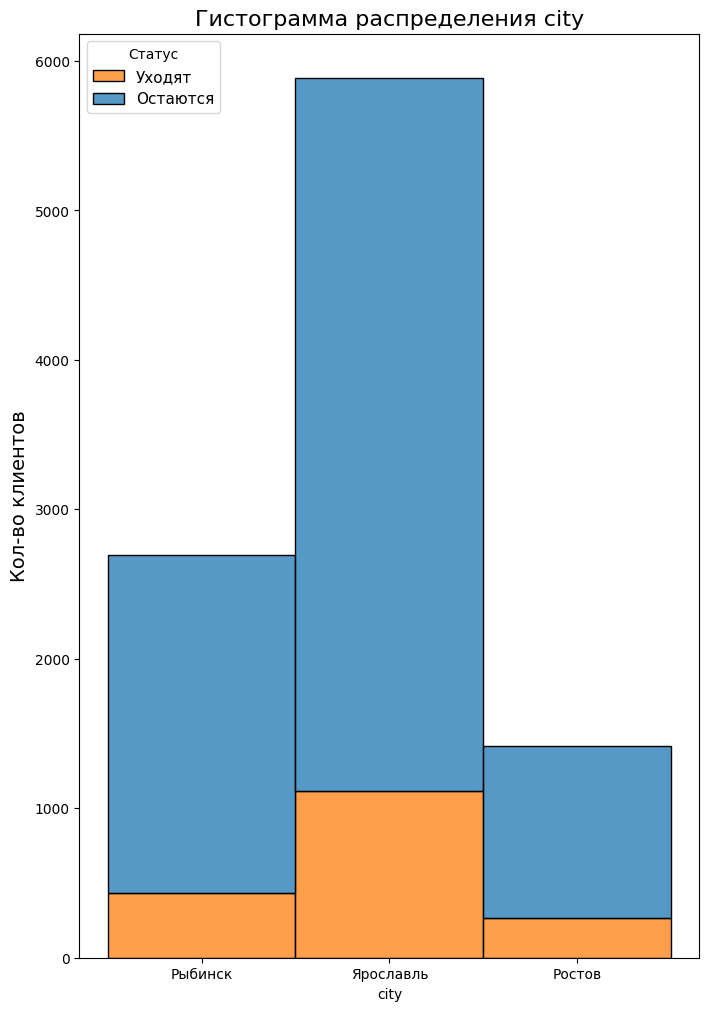

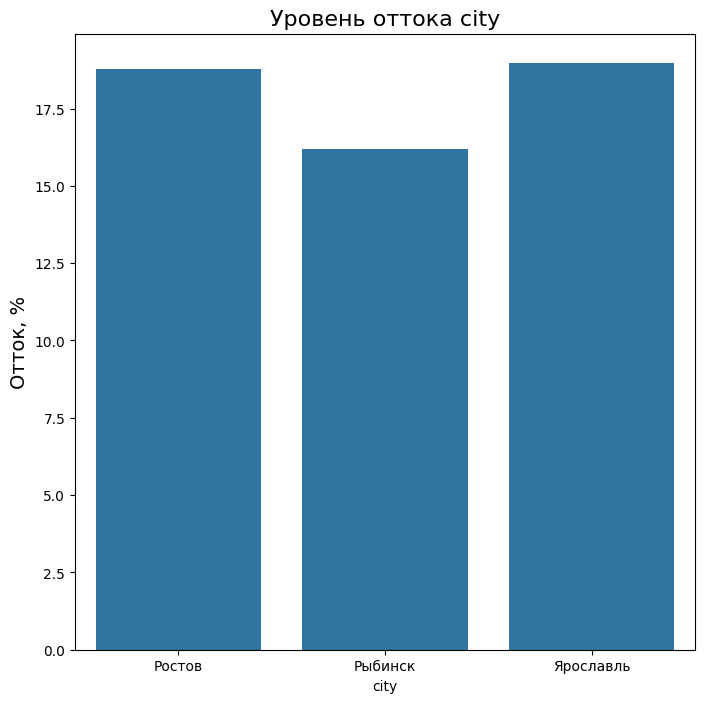

Средний отток клиентов внутри всей категории по банку: 606 Доля, %: 17
3


In [48]:
disc_values('city')

Доли оттока почти одинаковые в каждом городе.

**Распределение:** больше всего людей уходит в Ярославле. Это связано с тем, что в этом городе больше всего клиентов.

#### Анализ клиентов по полу

,gender,0,1,churn
0,Ж,4358,636,12.74
1,М,3822,1183,23.64


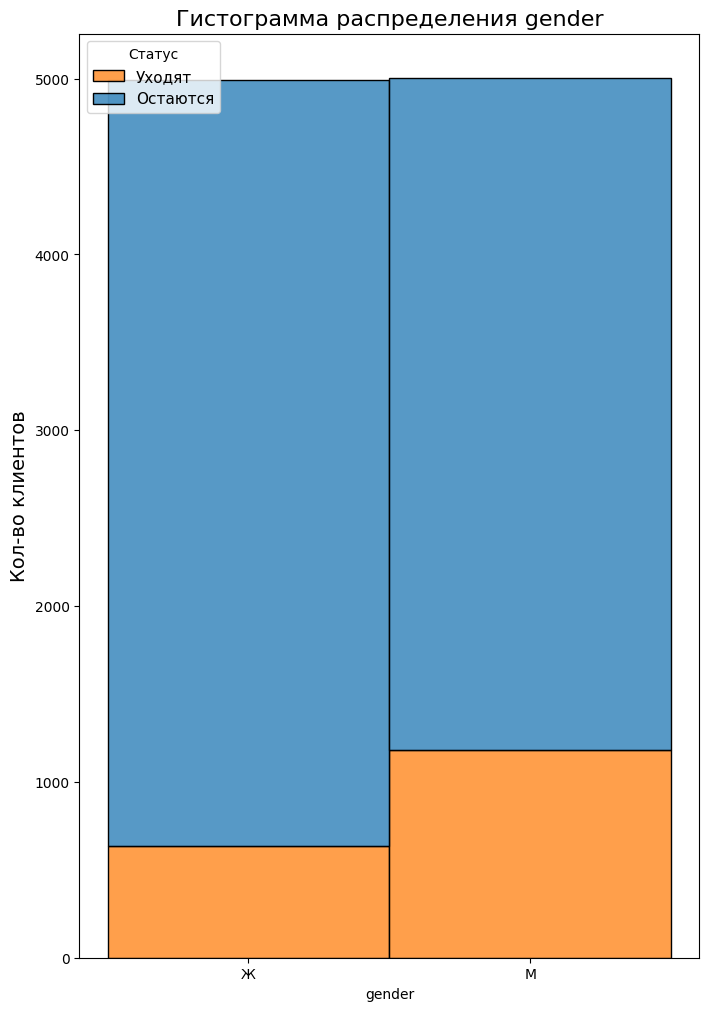

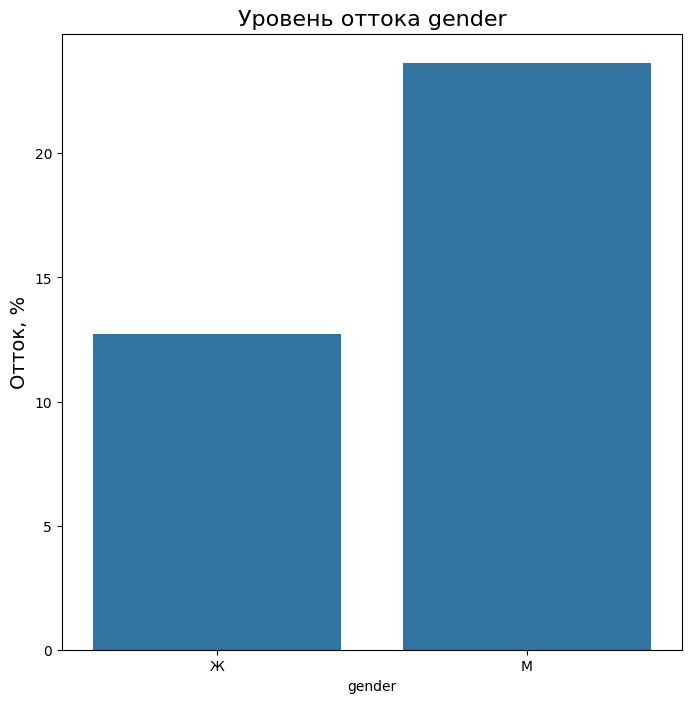

Средний отток клиентов внутри всей категории по банку: 909 Доля, %: 18
2


In [49]:
disc_values('gender')

Среди мужчин доля оттока почти 2 раза выше, чем среди женщин и составляет 23,64%, что выше среднего показателя.

**Распределение:** также видно, что мужчины практически в 2 раза чаще уходят в отток.

#### Анализ клиентов по баллам собственности

,equity,0,1,churn
0,0,2502,90,3.47
1,1,681,93,12.02
2,2,886,166,15.78
3,3,1221,321,20.82
4,4,1386,464,25.08
5,5,1341,577,30.08
6,6,103,58,36.02
7,7,43,37,46.25
8,8,11,6,35.29
9,9,6,7,53.85


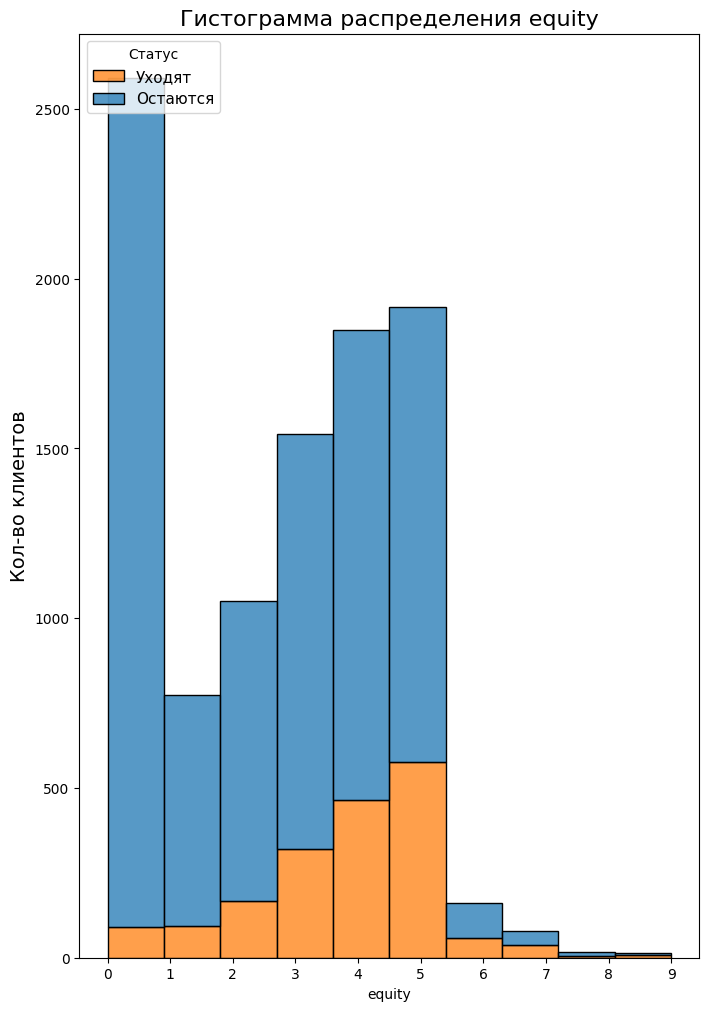

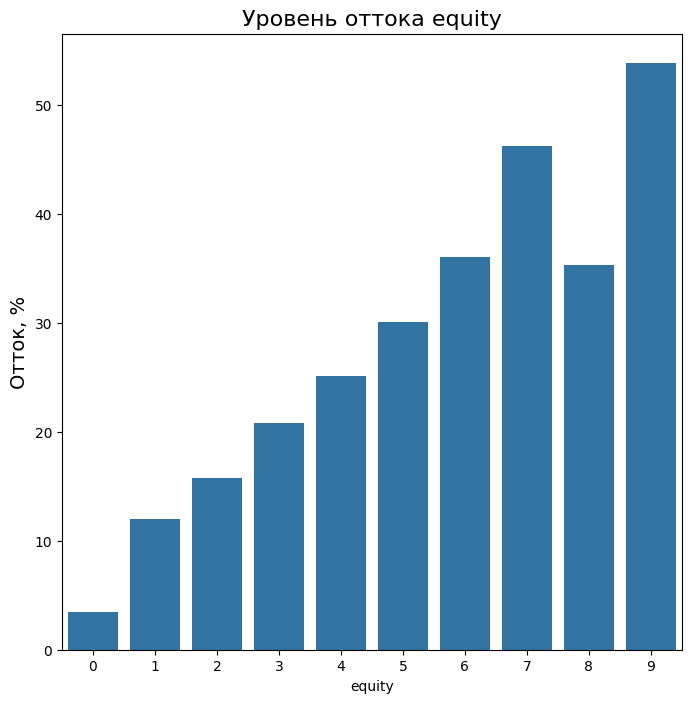

Средний отток клиентов внутри всей категории по банку: 181 Доля, %: 27
10


In [50]:
disc_values('equity')

Отток по баллам собственности можно разбить на группы отточности:

**Низкая:** 0 баллов (3,47%);

**Средняя:** 1-3 балла (12,3% — 20,87%);

**Высокая:** 4-5 баллов (25,08% — 30,08%);

**Очень высокая:** 6-9 баллов (35,29% — 53,85%).

**Распределение:** наибольший отток приходится на клиентов, имеющих от 3 до 5 баллов собственности.

#### Анализ клиентов по количеству банковских продуктов

,products,0,1,churn
0,1,3106,235,7.03
1,2,4147,979,19.10
2,3,742,297,28.59
3,4,174,300,63.29
4,5,11,8,42.11


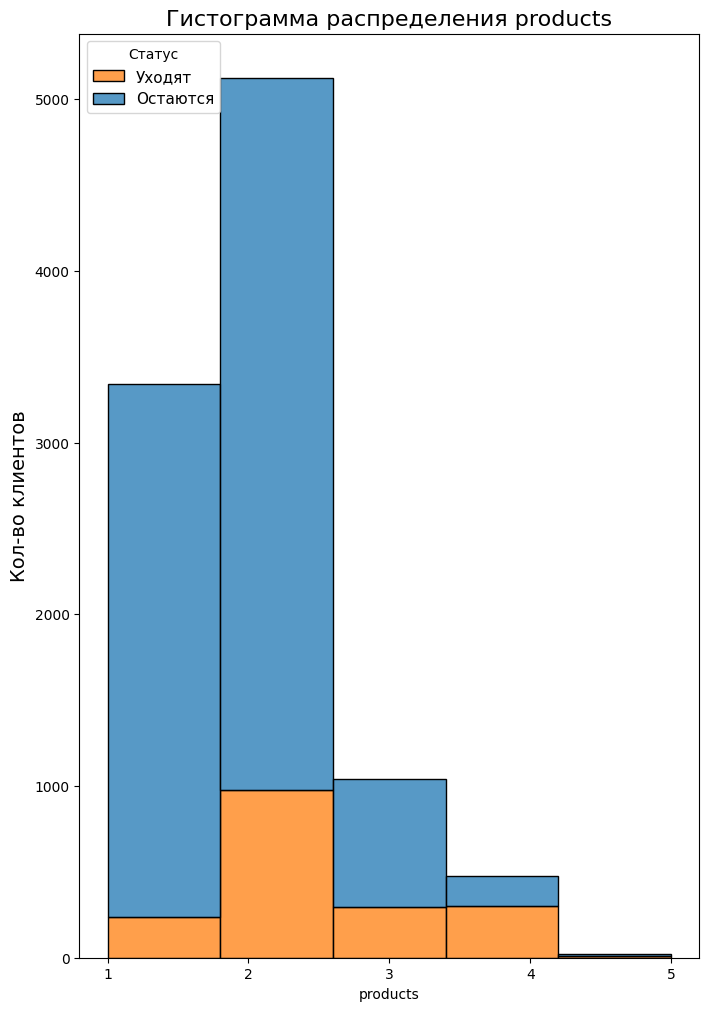

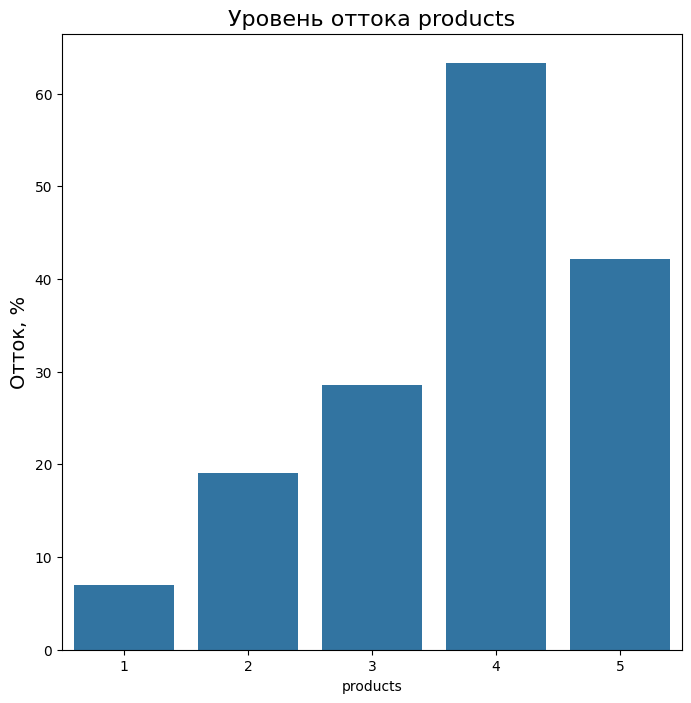

Средний отток клиентов внутри всей категории по банку: 363 Доля, %: 32
5


In [51]:
disc_values('products')

Самыми отточными являются клиенты у которых, включительно, более 2 банковских продуктов.

**Распределение:** больше всего клиектов уходит в отток с 2 банковскими продуктами, а у клиентов с 4 отток превышаюет действующих.

#### Анализ клиентов по наличию кредитной карты

,credit_card,0,1,churn
0,0,2379,816,25.54
1,1,5801,1003,14.74


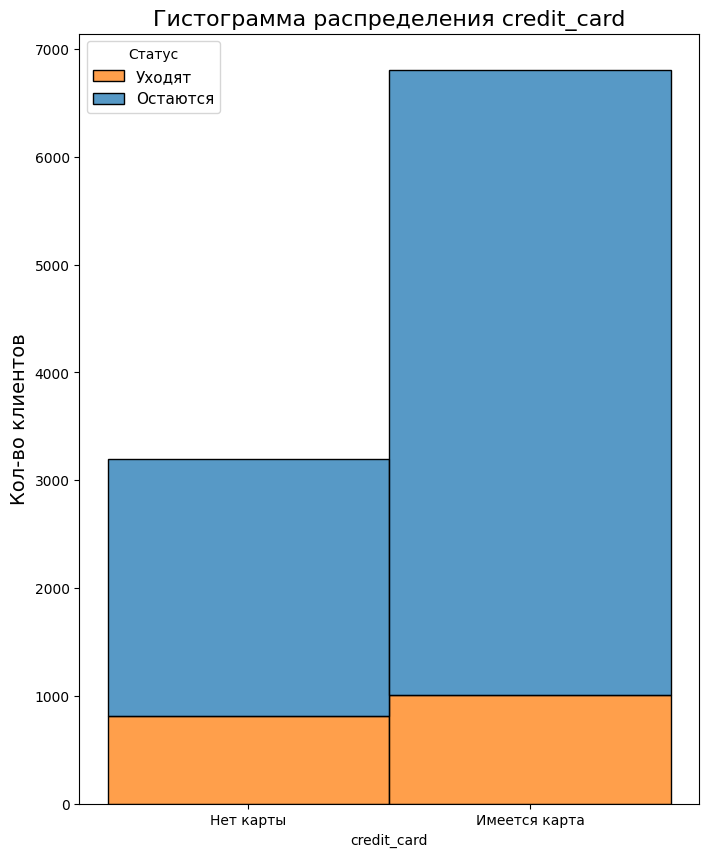

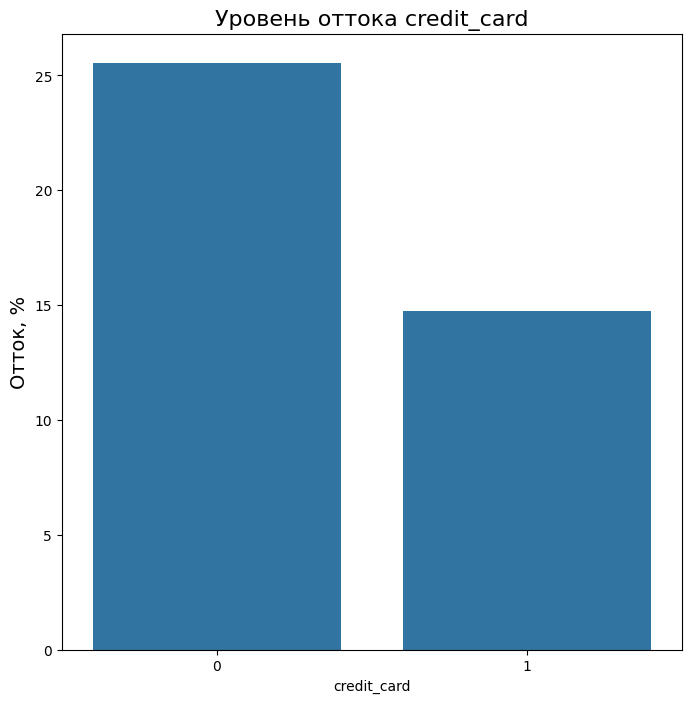

Средний отток клиентов внутри всей категории по банку: 909 Доля, %: 20


In [52]:
binary_disc_values('credit_card', 'Нет карты', 'Имеется карта')

Наличие или отсутсвие кредитной практически никак не влияет на отток.

#### Анализ клиентов по последней активности

,last_activity,0,1,churn
0,0,4223,541,11.36
1,1,3957,1278,24.41


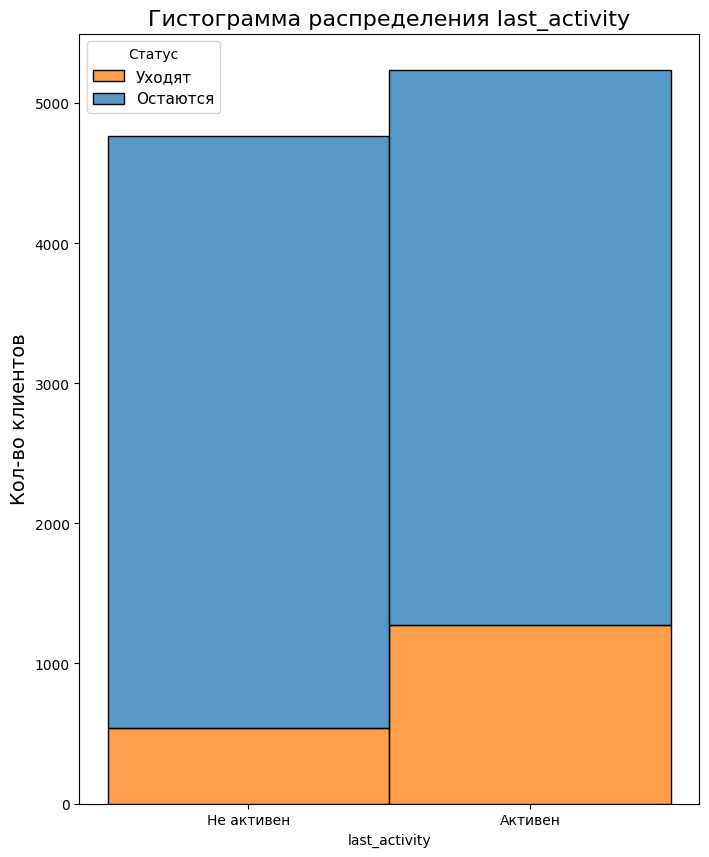

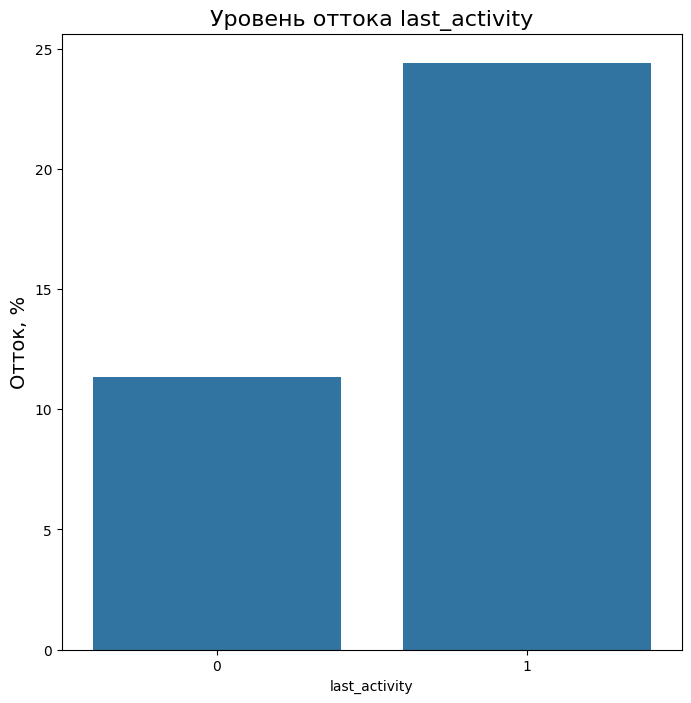

Средний отток клиентов внутри всей категории по банку: 909 Доля, %: 17


In [53]:
binary_disc_values('last_activity', 'Не активен', 'Активен')

Отточность у клиентов, которые были недавно активны почти в 2,5 раза больше, чем у клиентов, которые не были активны последние 30 дней.

**Распределение:** также видно, практически в 2,5 раза отток происходит у клиентов, которые были активны.

### Влияние признаков на отток

Рассчитаем матрицу корреляций и на её основе построим тепловую карту.

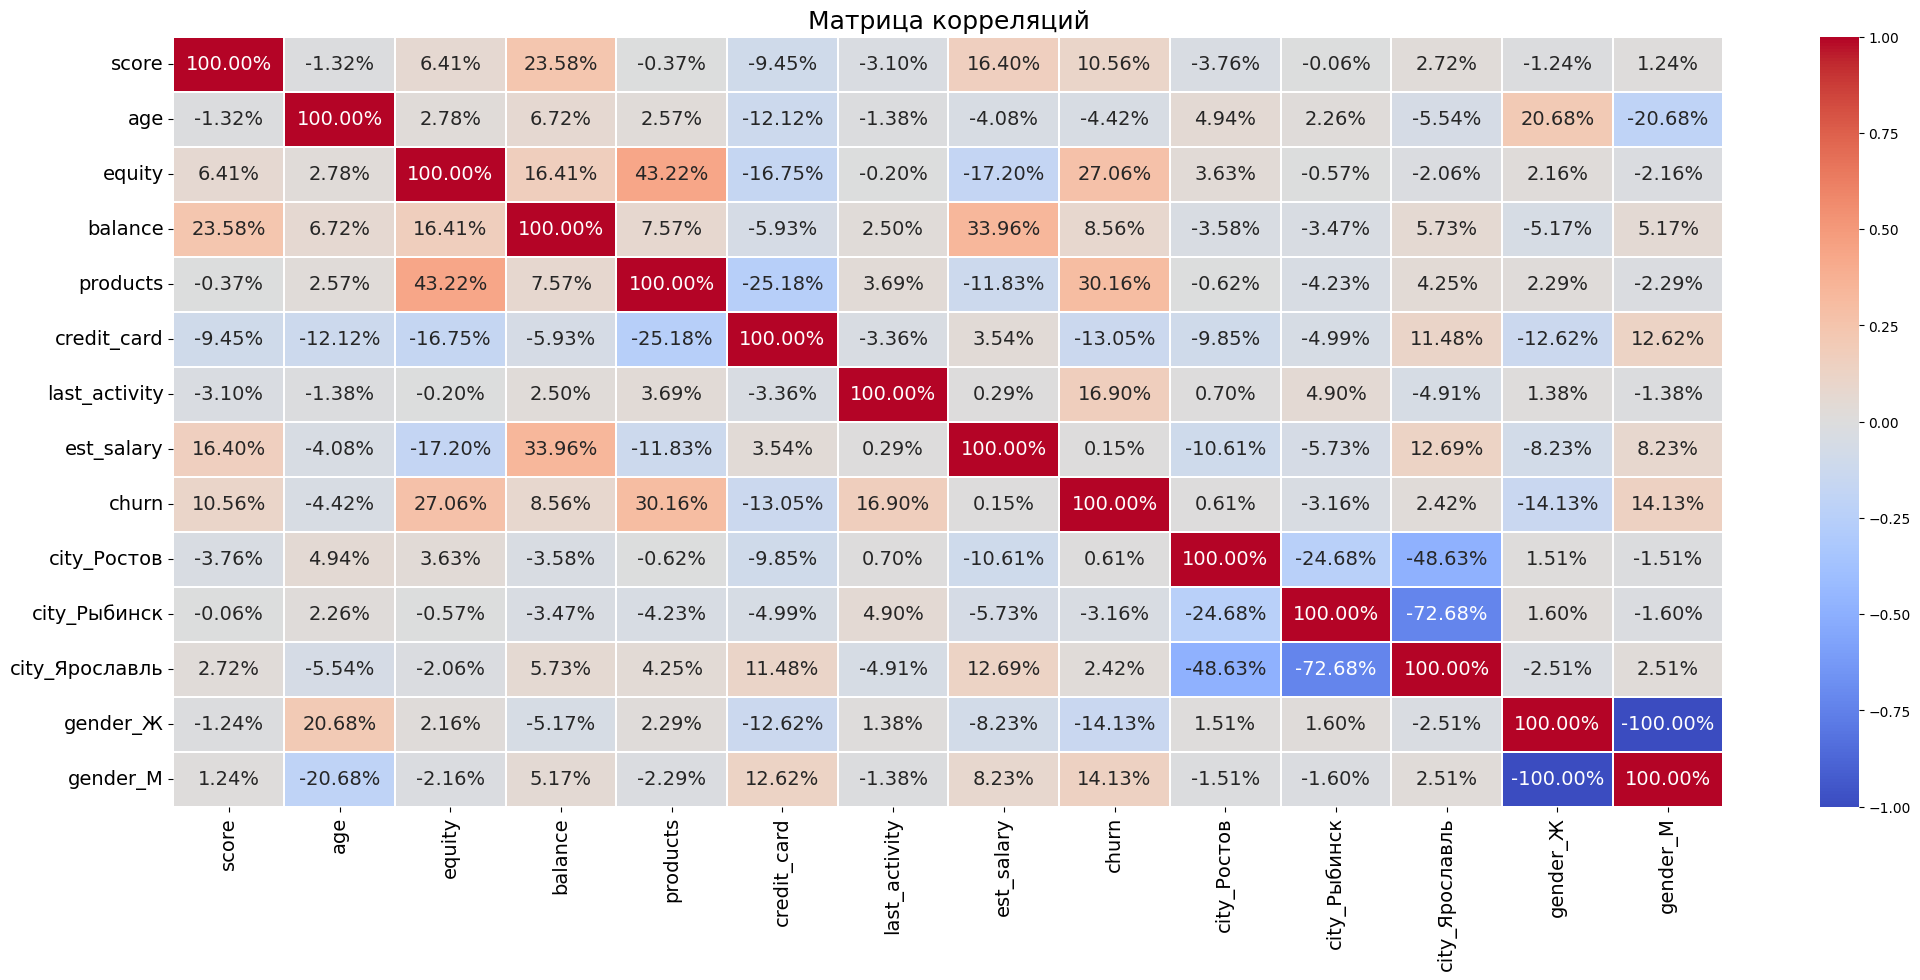

In [54]:
cm = df.drop(['user_id', 'city', 'gender'], axis=1).corr()

plt.figure(figsize=(25, 10))
sns.heatmap(cm, annot=True,
            fmt='.2%', square=False, cmap='coolwarm', linewidths=0.25,
            annot_kws={'fontsize':14})
plt.title('Матрица корреляций', fontsize = 18)
plt.xticks(rotation = 'vertical', fontsize = 14)
plt.yticks(rotation = 'horizontal', fontsize = 14)
plt.show()

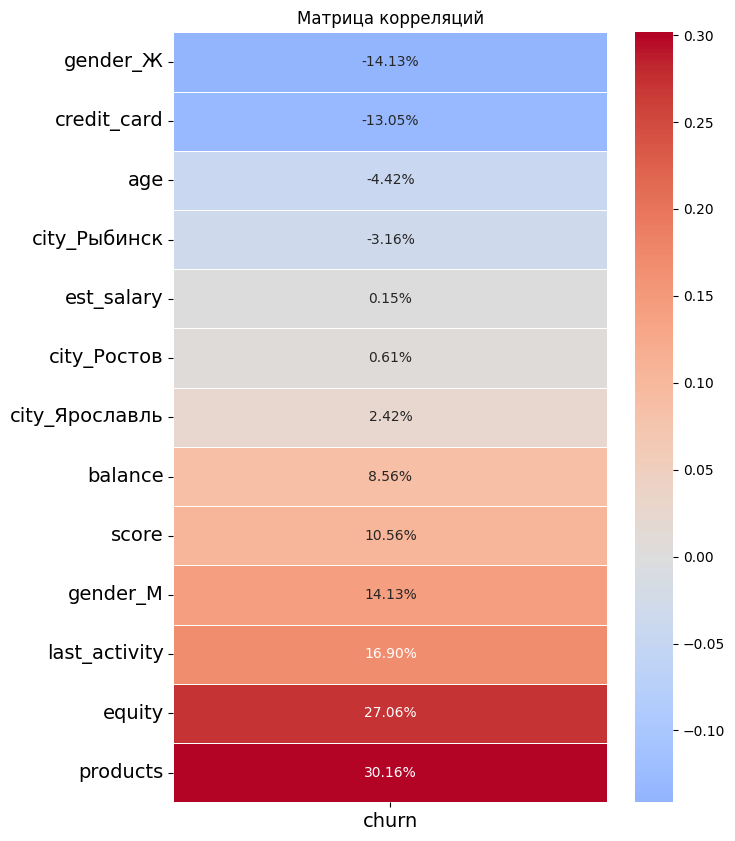

In [55]:
plt.figure(figsize=(7, 10))
sns.heatmap(cm.loc[:,['churn']].drop('churn').sort_values('churn'), annot=True,
            fmt='.2%', cmap='coolwarm',center=0, linewidths=0.5)
plt.title('Матрица корреляций')
plt.xticks(rotation = 'horizontal', fontsize = 14)
plt.yticks(rotation = 'horizontal', fontsize = 14)
plt.show()

**Слабая связь:**
* `est_salary` — оценочный доход клиента;
* `city_Ростов` — Ростов
* `city_Ярославль` — Ярославль;

**Умеренная связь:**
* `score` — баллы кредитного скоринга;
* `balance` — баланс на счёте;
* `gender_М` — клиенты-мужчины;
* `last_activity` — был ли клиент активен последнее время;
* `equity` — количество баллов собственности;
* `products` — количество продуктов, которыми пользуется клиент;

**Не оказывают влияния на отток:**

(*имеют слабую обратную связь*)
* `city_Рыбинск` — Рыбинск;
* `gender_Ж` — клиенты-женщины;
* `age` — возраст;
* `credit_card` — есть ли кредитная карта;

### Вывод

**Обратить внимание стоит на следующие группы клиентов на основании результатов:**

(*данные диапазоны не являются решением проблемы или отточными сегментами, а лишь ориентирами при составлении сегментов*)

**Баллы кредитного скоринга:** от 790 до 910 баллов (10,56%);

**Возраст:** от 25 до 33 лет и от 50 до 60 лет (корреляция обратная, но это связано с тем, что она проводилась по всему датасету);

**Баланс на счете:** от 750 тыс. (8,56%);

**Оценочный доход:** от 85 тыс. до 180 тыс. (0,15%);

**Баллы собствености:** от 5 до 9 баллов (27,06%);

**Количество банковских продуктов:** от 3 до 5 (30,16%);

**Поледняя активность:** клиеты, которые были недавно активны почти в 2,5 раза больше, чем у клиентов, которые не были активны последние 30 дней (16,9%).

## Проверка гипотез

У нас имеется 4 гипотезы:

- Различие дохода между теми клиентами, которые ушли и теми, которые остались;
- Различие баланса на счете между теми клиентами, которые ушли и теми, которые остались;
- Различие баллов кредитного скоринга между теми клиентами, которые ушли и теми, которые остались;
- Различие количества банковских продуктов между теми клиентами, которые ушли и теми, которые остались.


В рамках данного проекта в качестве `α` (alpha — порогового уровеня статистической значимости) будет принято значение в размере 5% (0.05).

Методы для проверки гипотез будут объявлены в каждом шаге.

In [56]:
alpha = 0.05 # значение уровня значимости

Можно было бы уменьшить значение, т.к. цена ошибки высока, но это не особо на что-то повлияет и 5% оптимальны по отношению к исследуемым параметрам.

### Различие дохода между теми клиентами, которые ушли и теми, которые остались

Данная гипотеза будет проверена t-критерием и u-критерием.

Проверка гипотезы:

Доходы между теми клиентами, которые ушли и теми, которые остались одинаковые;

```
H_0: Доход оставшихся клиентов = Доход ушедших клиентов
H_1: Доход оставшихся клиентов ≠ Доход ушедших клиентов
alpha = 0.05
```

Создадим переменные для наших выборок.

In [57]:
est_salary_stayed = df.query('churn == 0')['est_salary']
est_salary_left = df.query('churn == 1')['est_salary']

Сравним средние и дисперсии выборок:

In [58]:
print('Средний доход оставшихся клиентов:', est_salary_stayed.mean())
print('Среднее доход ушедших клиентов:', est_salary_left.mean())
print()
print('Соотношение средних доходов оставшихся и ушедших клиентов:', est_salary_left.mean() / est_salary_stayed.mean())


Средний доход оставшихся клиентов: 147783.20010757947
Среднее доход ушедших клиентов: 148310.72820230896

Соотношение средних доходов оставшихся и ушедших клиентов: 1.0035696080092018


In [59]:
print('Дисперсия дохода оставшихся клиентов:', np.var(est_salary_stayed))
print('Дисперсия дохода ушедших клиентов:', np.var(est_salary_left))
print()
print('Соотношение дисперсий доходов оставшихся и ушедших клиентов:', np.var(est_salary_left) / np.var(est_salary_stayed))

Дисперсия дохода оставшихся клиентов: 20390026478.417816
Дисперсия дохода ушедших клиентов: 15099630339.646345

Соотношение дисперсий доходов оставшихся и ушедших клиентов: 0.7405400064403456


In [60]:
results = stats.ttest_ind(
    est_salary_left,
    est_salary_stayed,
    equal_var=False)

# вывод значения p-value на экран
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.8724727072323815
Не получилось отвергнуть нулевую гипотезу


Значит доходы ушедших и оставшихся клиентов с вероятностью 11.2% одинаковые.

In [61]:
results = stats.mannwhitneyu(
    est_salary_left,
    est_salary_stayed,
    alternative='two-sided'
)

# вывод значения p-value на экран
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

0.00021160652203623057
Отвергаем нулевую гипотезу


Значит доходы ушедших и оставшихся клиентов разные. Вероятность, что они одинаковые составляет 0.02%.

Результаты разнятся из-за того, что для t-критерия выборки должны иметь нормальное распределение, и их
дисперсии должны быть равны, но в нашем случае дисперсии разные.

Условием для применения U-критерия Манна-Уитни является отсутствие в сравниваемых группах совпадающих значений признака (все числа – разные) или очень малое число таких совпадений.

U-критерий Манна-Уитни является непараметрическим критерием, поэтому, в отличие от t-критерия Стьюдента, не требует наличия нормального распределения сравниваемых совокупностей, что является его единственным преимуществом.

В нашем случае расхождения есть, но на мой взгляд они минимальны, однако в данных часто бывает много шумов и выбросов, поэтому t-test неприменим по соображениям мощности, чувствительности или ненормальности данных, а Манн-Уитни в этот момент отлично срабатывает и более вероятно находит статистически значимый эффект.

### Различие баланса на счете между теми клиентами, которые ушли и теми, которые остались

Проверка гипотезы:

Балансы на счете между теми клиентами, которые ушли и теми, которые остались одинаковые;

```
H_0: Баланс на счете оставшихся клиентов = Баланс на счете ушедших клиентов
H_1: Баланс на счете оставшихся клиентов ≠ Баланс на счете ушедших клиентов
alpha = 0.05
```

Создадим переменные для наших выборок.

In [62]:
balance_stayed = df[~df['balance'].isna()].query('churn == 0')['balance']
balance_left = df[~df['balance'].isna()].query('churn == 1')['balance']

Сравним средние и дисперсии выборок:

In [63]:
print('Средний баланс на счете оставшихся клиентов:', balance_stayed.mean())
print('Среднее баланс на счете ушедших клиентов:', balance_left.mean())
print()
print('Соотношение средних баланса на счете оставшихся и ушедших клиентов:', balance_left.mean() / balance_stayed.mean())


Средний баланс на счете оставшихся клиентов: 733982.5856476771
Среднее баланс на счете ушедших клиентов: 1133993.271449917

Соотношение средних баланса на счете оставшихся и ушедших клиентов: 1.5449866163367685


In [64]:
print('Дисперсия баланс на счете оставшихся клиентов:', np.var(balance_stayed))
print('Дисперсия баланс на счете ушедших клиентов:', np.var(balance_left))
print()
print('Соотношение дисперсий баланса на счете оставшихся и ушедших клиентов:', np.var(balance_left) / np.var(balance_stayed))

Дисперсия баланс на счете оставшихся клиентов: 3819706737858.5366
Дисперсия баланс на счете ушедших клиентов: 4134778049593.231

Соотношение дисперсий баланса на счете оставшихся и ушедших клиентов: 1.0824857334234341


In [65]:
results = stats.ttest_ind(
    balance_left,
    balance_stayed,
    equal_var=False)

# вывод значения p-value на экран
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

2.0439782929669127e-13
Отвергаем нулевую гипотезу


In [66]:
results = stats.mannwhitneyu(
    balance_left,
    balance_stayed,
    alternative='two-sided'
)

# вывод значения p-value на экран
print(results.pvalue)

# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

2.4600499882458142e-70
Отвергаем нулевую гипотезу


На имеющихся данных, на уровне значимости 5% есть основания отвергнуть нулевую гипотезу о равенстве баланса на счете между теми клиентами, которые ушли и теми, которые остались.

### Вывод

Мы проверили каждую гипотезу через t- и u-критерии.

- Шанс одинакового дохода у ушедших и действующих клиентов практически невозможен.
- Балансы среди ушедишх и действующих клиентов по обеим гипотезам не могут быть одинаковыми в принципе.

Если в данные не отфильтрованы, либо выборкам присущи шумы, то u-критерий показывает себя точнее, особенно если дисперсии сильно отличаются.

## Сегментация клиентов

Проведем сегментацию, комбинируя 2 или более признаков клиентов, отбирая группы, подходящие по критериям, в последствии обозначая их как сегменты.

Отдел маркетинга в качестве основных критериев для сегментации выделил следуюшие:
- отток более чем в 2 раза больше среднего по банку;
- размер сегмента менее 100-500 человек.

Так как отдел небольшой, то в данный момент критерии таковы, также для данного этапа работы им не требуется много и большие сегменты.

Для этого создадим функцию, чтобы можно было понимать подходит нам сегмент или нет.

In [67]:
#на вход подается срез для query-запроса в формате 'запрос',
#после выдается информация о размере сегмента, уровне оттока, количесте отточных и неотточных клиентов
def segment_info(params):
    data = df.query(params)
    df_churm = df['churn'].mean()*2
    count = data['churn'].count()
    mean_churn = data['churn'].mean()
    count_churn = data['churn'].sum()
    count_stayed = count - count_churn
    print(f"Размер сегмента: {count}.")
    print(f"Уровень оттока: {mean_churn:.2%}.")
    print(f"Количество отточных клиентов: {count_churn}.")
    print(f"Количество неотточных клиентов: {count_stayed}.")
    print()
    if df_churm <= mean_churn < 0.5:
        print(f"Достаточно отточный сегмент: {mean_churn:.2%}.")
    elif 0.5 <= mean_churn < 0.7:
        print(f"Сильно отточный сегмент: {mean_churn:.2%}.")
    elif mean_churn >= 0.7:
        print(f"Суперотточный сегмент: {mean_churn:.2%}.")
    else:
        print(f"Слишком неотточный сегмент: {mean_churn:.2%}.")

**Выбор сегментов** будет основываясь на размере оттока, а потом уже на уровне, чтобы максимально точечно определить основную проблему. Дополнительные признаки будут задаваться, чтобы дать рекомендации по сегменту.

### Мужчины предпенсионного возраста

In [68]:
segment_info('45 <= age < 60 and gender_Ж == 1')

Размер сегмента: 1340.
Уровень оттока: 17.69%.
Количество отточных клиентов: 237.
Количество неотточных клиентов: 1103.

Слишком неотточный сегмент: 17.69%.


In [69]:
segment_info('50 <= age < 65 and gender_М == 1')

Размер сегмента: 906.
Уровень оттока: 31.13%.
Количество отточных клиентов: 282.
Количество неотточных клиентов: 624.

Слишком неотточный сегмент: 31.13%.


Типичные мужчины и женщины предпенсионного возраста не попадают в отточные сегменты, но видно, что больше мужчик уходит в отток. Попробуем добавить параметры, чтобы выйявить проблемный сегмент.

In [70]:
segment_info('50 <= age <= 60 and gender == "М" and credit_card == 0 and last_activity == 1')

Размер сегмента: 163.
Уровень оттока: 48.47%.
Количество отточных клиентов: 79.
Количество неотточных клиентов: 84.

Достаточно отточный сегмент: 48.47%.


In [71]:
segment_info('50 <= age <= 60 and gender == "М" and credit_card == 0')

Размер сегмента: 280.
Уровень оттока: 43.93%.
Количество отточных клиентов: 123.
Количество неотточных клиентов: 157.

Достаточно отточный сегмент: 43.93%.


In [72]:
segment_info('50 <= age <= 60 and credit_card == 0 and last_activity == 1')

Размер сегмента: 395.
Уровень оттока: 44.30%.
Количество отточных клиентов: 175.
Количество неотточных клиентов: 220.

Достаточно отточный сегмент: 44.30%.


In [73]:
segment_info('50 <= age <= 60 and credit_card == 0 and 90000 < est_salary <= 220000')

Размер сегмента: 384.
Уровень оттока: 40.89%.
Количество отточных клиентов: 157.
Количество неотточных клиентов: 227.

Достаточно отточный сегмент: 40.89%.


In [74]:
segment_info('50 <= age <= 60 and products <= 2 and credit_card == 0 and last_activity == 1 and 90000 < est_salary <= 220000')

Размер сегмента: 170.
Уровень оттока: 48.24%.
Количество отточных клиентов: 82.
Количество неотточных клиентов: 88.

Достаточно отточный сегмент: 48.24%.


**Предсегментация:** данная категория мужчин является отточной вне зависимости от наличия недавней активности.

**Сегмент "мужчины предпенсионного возраста":**
- размер сегмента: 395 человек;
- отточность 44,3% (достаточная - выше средней);
- возраст: от 50 до 60 лет (включительно);
- мужской пол;
- отсутсвует кредитная карта;
- была недавняя активность.

### Начинающие карьеристы

In [75]:
segment_info('age < 35 and credit_card == 0 and est_salary > 60000')

Размер сегмента: 589.
Уровень оттока: 39.05%.
Количество отточных клиентов: 230.
Количество неотточных клиентов: 359.

Достаточно отточный сегмент: 39.05%.


In [76]:
segment_info('age < 35 and equity <= 4 and credit_card == 0 and 35000 < est_salary < 120000')

Размер сегмента: 306.
Уровень оттока: 29.74%.
Количество отточных клиентов: 91.
Количество неотточных клиентов: 215.

Слишком неотточный сегмент: 29.74%.


In [77]:
segment_info('age < 35 and equity <= 4 and 55000 < est_salary < 150000 and products <= 3')

Размер сегмента: 1248.
Уровень оттока: 16.19%.
Количество отточных клиентов: 202.
Количество неотточных клиентов: 1046.

Слишком неотточный сегмент: 16.19%.


**Сегмент "начинающие карьеристы":**
- размер сегмента: 589 человек;
- отточность 39,05% (достаточная - в 2 раза выше средней);
- возраст: от 18 до 34 лет (включительно);
- мужской и женский пол;
- отсутсвует кредитная карта;
- доход от 60 тыс. руб.

В данном сегменте предположительно находятся недавние студенты с низким средним баллом собственности и отсутсвующей кредитной картой.

### Премиальные клиенты

Для Москвы и МО данные клиенты не относились бы к примиальным, однако, в рамках регионов небоходимая сумма для премиального обслуживания, которое предполагает помощь персональног менеджера, начинается от 1 млн. руб. (в зависимости от банка).

In [78]:
segment_info('balance >= 1000000 and products >= 3')

Размер сегмента: 599.
Уровень оттока: 54.76%.
Количество отточных клиентов: 328.
Количество неотточных клиентов: 271.

Сильно отточный сегмент: 54.76%.


In [79]:
segment_info('balance >= 1000000 and products >= 4')

Размер сегмента: 238.
Уровень оттока: 82.35%.
Количество отточных клиентов: 196.
Количество неотточных клиентов: 42.

Суперотточный сегмент: 82.35%.


На данном этапе предсегментации видно, что проблему у премиальных клиентов с 4 и более продуктами.

In [80]:
segment_info('balance >= 1000000 and products >= 4 and credit_card == 1')

Размер сегмента: 170.
Уровень оттока: 90.00%.
Количество отточных клиентов: 153.
Количество неотточных клиентов: 17.

Суперотточный сегмент: 90.00%.


In [81]:
segment_info('balance >= 1000000 and products >= 4 and last_activity == 0')

Размер сегмента: 78.
Уровень оттока: 92.31%.
Количество отточных клиентов: 72.
Количество неотточных клиентов: 6.

Суперотточный сегмент: 92.31%.


In [82]:
segment_info('balance >= 1000000 and products >= 4 and last_activity == 1')

Размер сегмента: 160.
Уровень оттока: 77.50%.
Количество отточных клиентов: 124.
Количество неотточных клиентов: 36.

Суперотточный сегмент: 77.50%.


In [83]:
segment_info('balance >= 1000000 and products >= 4 and credit_card == 1 and last_activity == 1')

Размер сегмента: 112.
Уровень оттока: 87.50%.
Количество отточных клиентов: 98.
Количество неотточных клиентов: 14.

Суперотточный сегмент: 87.50%.


**Предсегментация:** первую очередь наблюдается факт проблем с кредитными картами, а на втором плане видна проблема среди клиентов, имеющих достаточную сумму денег на счету и активно пользующихся большим количеством продуктов, т.е. более 3-х, что свойственно премиальному сегменту клиентов. Активность никак не влияет на снижение оттока, однако, за последний месяц таких клиентов ушло в 2 раза больше, что говорит о серьезных проблемах в данном сегменте.

**Сегмент "Премиум":**
- размер сегмента: 599 человек;
- отточность 54,76% (сильно отточный - в 3 выше средней);
- баланс: от 1 млн. руб.;
- количество продуктов: более 3.

### Клиенты с кредитной историей

Для начала ознакомимся с ориентировочными значениями кредитного рейтинга (у каждого банка могут быть свои подгруппы):
    
**800 — 1000**:
Вы отличный заемщик, шансы получить кредит максимальны!

**600 — 800:**
У вас хорошие шансы получить кредит.

**400 — 600:**
Получение кредита возможно, но не гарантированно.

**0 — 400:**
Вероятность получения кредита крайне мала.

*Если клиент никогда раньше не брали кредиты и не пользовался кредитными картами, то его КИ будет чистой.*

Из этого можно предположить, что данная группа имеет место быть, т.к. клиенты имеют высокий рейтинг, хорошие баллы собственности, но при этом у них отсутствует кредитная карта нашего банка.

В качествве ввдоных данных рассмотрим клиентов со следующими параметрами:
- оценочный доход от 80 тыс.;
- баллы собственности от 5 - это средний балл в метрике;
- отсутсвует кредитная карта;
- скоринговые баллы от 600 и 800, т.к. такие клиенты потенциально имеют выоские шансы получить кредит или кредитную карту.

In [84]:
segment_info('score >= 600 and equity >= 5 and credit_card == 0 and est_salary > 80000')

Размер сегмента: 664.
Уровень оттока: 43.52%.
Количество отточных клиентов: 289.
Количество неотточных клиентов: 375.

Достаточно отточный сегмент: 43.52%.


In [85]:
segment_info('score >= 800 and equity >= 5 and credit_card == 0 and est_salary > 80000')

Размер сегмента: 624.
Уровень оттока: 45.67%.
Количество отточных клиентов: 285.
Количество неотточных клиентов: 339.

Достаточно отточный сегмент: 45.67%.


In [86]:
segment_info('score >= 600 and equity >= 5 and credit_card == 0 and est_salary > 80000 and products == 2 and balance > 1')

Размер сегмента: 440.
Уровень оттока: 42.73%.
Количество отточных клиентов: 188.
Количество неотточных клиентов: 252.

Достаточно отточный сегмент: 42.73%.


**Предсегментация:** наличие хороших баллов кредитного скоринга не особо влияет, поэтому предположим, что в данном сегменте находятся клиенты с кредитом и имеют не нулевой баланс.

**Сегмент "Кредитные услуги":**
- размер сегмента: 624 человек;
- отточность 45,67% (достаточная - в ~2,4 раза выше средней);
- баллы кредитного скоринга от 800;
- баллы собственности от 5;
- оценочный доход от 80 тыс;
- отсутсвует кредитная карта;
- предположительно имеется кредит.

### Приоритизация сегментов

Начать стоит с приортизацию стоит в следуюшем порядке:

**Сегмент "Премиум":**
- Второй по размеру сегмент: 599 человек;
- отточность 54,76% (в 3 раза выше средней).

Данный сегмент первым по приоритету, потому что данные клиенты имеют более 1 млн. руб. на балансе, что почти на 30% выше среднего значения по банку, а также пользуются большим количеством продуктов. За счет данных клиентов банк формирует большую часть бюджета, а также он имеет самую большую отточность.

**Сегмент "Кредитные услуги":**
- Первый по размеру сегмента: 624 человека;
- отточность 45,67% (в ~2,4 раза выше средней).

Данный сегмент является вторым по приоритету, т.к. является вторым по оттоку и кредитование является важной частью банковской сфера в плане статьи дохода, а также является первым по оттоку и имеет 624 потенциальных клиента, которые могут оформить кредитную карту.

**Сегмент "мужчины предпенсионного возраста":**
- Четвертый по размеру сегмент: 395 человек;
- отточность 44,3% (выше средней в ~2,46 раза).

Данный сегмент является третьим по приоритету, потому что данные клиенты имеют более высокий доход по сравнению с "начинающими карьеристами", а также потенциально могут быть заинтересованы в инвестиционных и пенсионных программах, открытии кредитной карты и оформления кредитов под другие нужды. Также если мы выясним причины оттока данного "возрастного" сегмента, то сможем положительно повлиять на отток мужчин от 50 до 60 лет в других сегментах. Также в ходе анализа мы увидели, что мужской пол имеет почти 2 раза более высокую отточность по банку.

**Сегмент "начинающие карьеристы":**
- размер сегмента: 589 человек;
- отточность 39,05% (в 2 раза выше средней).

Данный сегмнет является последним по приоритету, т.к. аудитория только знакомится с банковскими продуктами, а также не все из них достаточно платежесобны для банка как приоритные клиенты. Также стоит отменить, что приоритизация других сегментов по итогу повлияет и на этот, т.к. другие сегменты точечно охватывают каждый продукт банка.

Также стоит отметить, что данная иерархия приоритизации снизит появление репутационных рисков, а также привлечет клиентов из схожих сегментов, которые положительно повлияют на прибыль банка.

## Вывод

В данном исследовании мы проанализировали данные по клиентам банка.

Перед тем как приступить к исследованию мы провели:

1. Предварительную обработку полученных данных - привели названия столбцов к нижнему регистру и типы данных, где это необходимо, провели проверку на пропущенные значения, дубликаты, нулевые значения.
2. Была проведена проверка на аномальные значения и выбросы в данных.
3. Провели исследовательский анализ данных и подробно изучили клиентские параметры.
4. Провели проверку двух гипотез с помощью t- и u-критериев.
5. Провели сегментацию отточных клиентов.

Исходя из проведенного анализа сделать следующие выводы:

**Склонны уходить клиенты, имеющие параметры в данных диапазонах (% корреляции):**

- **Баллы кредитного скоринга:** от 790 до 910 баллов (10,6%);

- **Возраст:** от 25 до 33 лет и от 50 до 60 лет (корреляция обратная, но это связано с тем, что она проводилась по всему датасету);

- **Баланс на счете:** от 750 тыс. (12,99%);

- **Оценочный доход:** от 85 тыс. до 180 тыс. (0,13%);

- **Баллы собствености:** от 5 до 9 баллов (27,06%);

- **Количество банковских продуктов:** от 3 до 5 (27,06%);

- **Поледняя активность:** клиенты, которые были недавно активны уходят почти в 2,5 раза чаще, чем клиенты, которые не были активны последние 30 дней (16,88%).

- Корреляция показала, что почти все параметры имеют умеренную связь по таблице Чеддока.
- Доход между ушедшими и оставшимися клиентами разный.
- Баланс между ушедшими и оставшимися клиентами совершенно разный.
- Если в данные не отфильтрованы, либо выборкам присущи шумы, то u-критерий показывает себя точнее, особенно если дисперсии сильно отличаются.

Также мы выделили 4 сегмента:

**Сегмент "мужчины предпенсионного возраста":**
- размер сегмента: 395 человек;
- отточность 44,3% (достаточная - выше средней);
- возраст: от 50 до 60 лет (включительно);
- мужской пол;
- отсутсвует кредитная карта;
- была недавняя активность.

**Сегмент "начинающие карьеристы":**
- размер сегмента: 589 человек;
- отточность 39,05% (достаточная - в 2 раза выше средней);
- возраст: от 18 до 34 лет (включительно);
- мужской и женский пол;
- отсутсвует кредитная карта;
- доход от 60 тыс. руб.

**Сегмент "Премиум":**
- размер сегмента: 599 человек;
- отточность 54,76% (сильно отточный - в 3 выше средней);
- баланс: от 1 млн. руб.;
- количество продуктов: более 3.

**Сегмент "Кредитные услуги":**
- размер сегмента: 624 человек;
- отточность 45,67% (достаточная - в ~2,4 раза выше средней);
- баллы кредитного скоринга от 800;
- баллы собственности от 5;
- оценочный доход от 80 тыс;
- отсутсвует кредитная карта;
- предположительно имеется кредит.

**Приоритизация сегментов:**
1. Премиум;
2. Кредитные услуги;
3. Мужчины предпенсионного возраста;
4. Начинающие карьеристы.

Данная иерархия приоритизации снизит появление репутационных рисков, а также привлечет клиентов из схожих сегментов, которые положительно повлияют на прибыль банка.

## Рекомедации

**Сегмент "мужчины предпенсионного возраста":**
Скорее всего данные клиенты пользуются вкладами, сберегательными считами или пенсионными программами. Кредитные продукты их скорее всего не интересуют, т.к. они имеют хороший доход (можно отнести к среднему классу) в рамках региона. Недавняя активность говорит о закрытии счета или выводе средств.

**Рекомендации:**
- предложить пенсионные программы;
- предложить потребительские кредиты на выгодных условиях;
- кредитные карты с большим лимитом;
- улучшение нативного опыта с приложением.


**Сегмент "начинающие карьеристы":**
Судя по описанию сегмента молодые клиенты недавно получили образование или только вступили на карьерную лестницу. Доход очень разнится, имеют не более 2-х продуктов, однако, кредитная карта отсутсвует.

**Рекомендации:**
- сделать промо выгодной ипотеки;
- предложить кредитные карты с хорошим беспроцентным периодом;
- предложить дебетовые карты с отличным кешбэком.
- предложить зарплатные карты.

**Сегмент "Премиум":**
Данный сегмент можно отнести к одним из самых активных пользователей банка, а также к тем, кто пользуется почти всеми услугами.

**Рекомендации:**
- проверить качество работы клиентского менеджера;
- подобрать индивидуальную инвестиционную программу;
- предложить  Priority Pass для комфортного ожидания в аэропорту;
- рассказать об услуга консьержа;
- предложить страховые продукты;
- рассказать о хорошей системе безопасности;
- пересмотреть ежедневные лимиты на снятие наличных в банкоматах;
- исследовать лимиты на переводы как со счетов, так и с дебетовых, и с кредитных карт.

**Сегмент "Кредитные услуги":**
Скорее всего в данном сегменте наблюдаются проблемы с получением кредитных карт, т.к. у клиентов есть записи в кредитной истории, либо у них наблюдаются какие-то проблемы с кредитом/ипотекой. Также они могут являться клиентами другого банка, возможно, что им предложили там более выгодные условия по кредиту или ипотеке, если они будут иметь счет, карту и другие услуги в их банке.

**Рекомендации:**
- пересмотреть условия по кредитным картам, как по выдаче, так и по обслуживанию, т.к. в обоих направлениях вероятнее всего есть проблемы;
- сделать промо кредитных услуг, т.к. вероятно не все знают о низких %;
- проанализировать предложения конкурентов.
